In [97]:

import sys
import shap 
import pickle
import sklearn 
import numpy as np
import pandas as pd
import seaborn  as sns
from pathlib import Path
import matplotlib.pyplot as plt
from types import SimpleNamespace



In [98]:



sys.path.append("../")

from dd_package.data.dyslexia_data import DyslexiaData
from dd_package.data.preprocess import preprocess_data

from dd_package.models.regression_estimators import RegressionEstimators

from dd_package.common.utils import save_a_dict, load_a_dict, print_the_evaluated_results

from dd_package.data.preprocess import minmax_standardizer_



In [99]:

configs = {
    "models_path": Path("/home/soroosh/Programmes/DD/Models"),
    "results_path": Path("/home/soroosh/Programmes/DD/Results"),
    "figures_path": Path("/home/soroosh/Programmes/DD/Figures"),
    "params_path": Path("/home/soroosh/Programmes/DD//Params"),
    "n_repeats": 10,
    "n_splits": 5,
}

configs = SimpleNamespace(**configs)



In [100]:

data_name="dd_fix_demo"

estimator_name = "mlp_cls"
to_shuffle = True
to_exclude_at_risk = 0




In [101]:

specifier = data_name + "-" + estimator_name + \
"--shuffled:" + str(to_shuffle) + \
"--exclude at risk:" + str(to_exclude_at_risk)



In [102]:
configs.specifier = specifier
configs.data_name = data_name



In [103]:

configs.specifier



'dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:0'

## Load Data

In [104]:


dd = DyslexiaData(path="../../datasets/", n_repeats=5)



In [105]:


if data_name == "dd_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    df_data_to_use = demo_phono.loc[:, [
                                           'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
                                       ]]
    c_features = ['Sex', 'Grade', ]
    indicators = ['SubjectID', ]
    targets = ["Group", "Reading_speed", ]

elif data_name == "dd_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    _ = dd.get_fix_datasets()  # fixes

    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_demo = dd.concat_dfs(
        df1=fix,
        df2=demo_phono,
        features1=fix.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", "Reading_speed", ]
    
elif data_name == "dd_fix":

    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_fix_datasets()  # fixes
    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]

    df_data_to_use = fix
    c_features = None
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", ]
    
    
    
    


x_org, y_org = dd.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)



x = preprocess_data(x=x_org, pp="mm")  # only x is standardized




features = dd.features
features





Loading Demo data: 
  dyslexia (72, 9)
  norm (213, 9)
  risk (22, 9)
 
Loading Fixation report data:
  dyslexia (59770, 7)
  norm (139507, 7)
  risk (26073, 7)
 
pre-processing: mm
Preprocessed data shape: (225350, 13)


['Grade_3',
 'Grade_6',
 'Grade_4',
 'FIX_DURATION',
 'Sex_1',
 'Sex_2',
 'FIX_Y',
 'Grade_1',
 'FIX_X',
 'Age',
 'IQ',
 'Grade_5',
 'Grade_2']

In [106]:


class_names = ['Norm', 'At-risk', 'Dyslexic']



# Data investigation (old data)

In [107]:

gx_o_n = fix_demo.loc[(fix_demo.Group==1)]
gx_o_r = fix_demo.loc[(fix_demo.Group==2)]
gx_o_d = fix_demo.loc[(fix_demo.Group==3)]



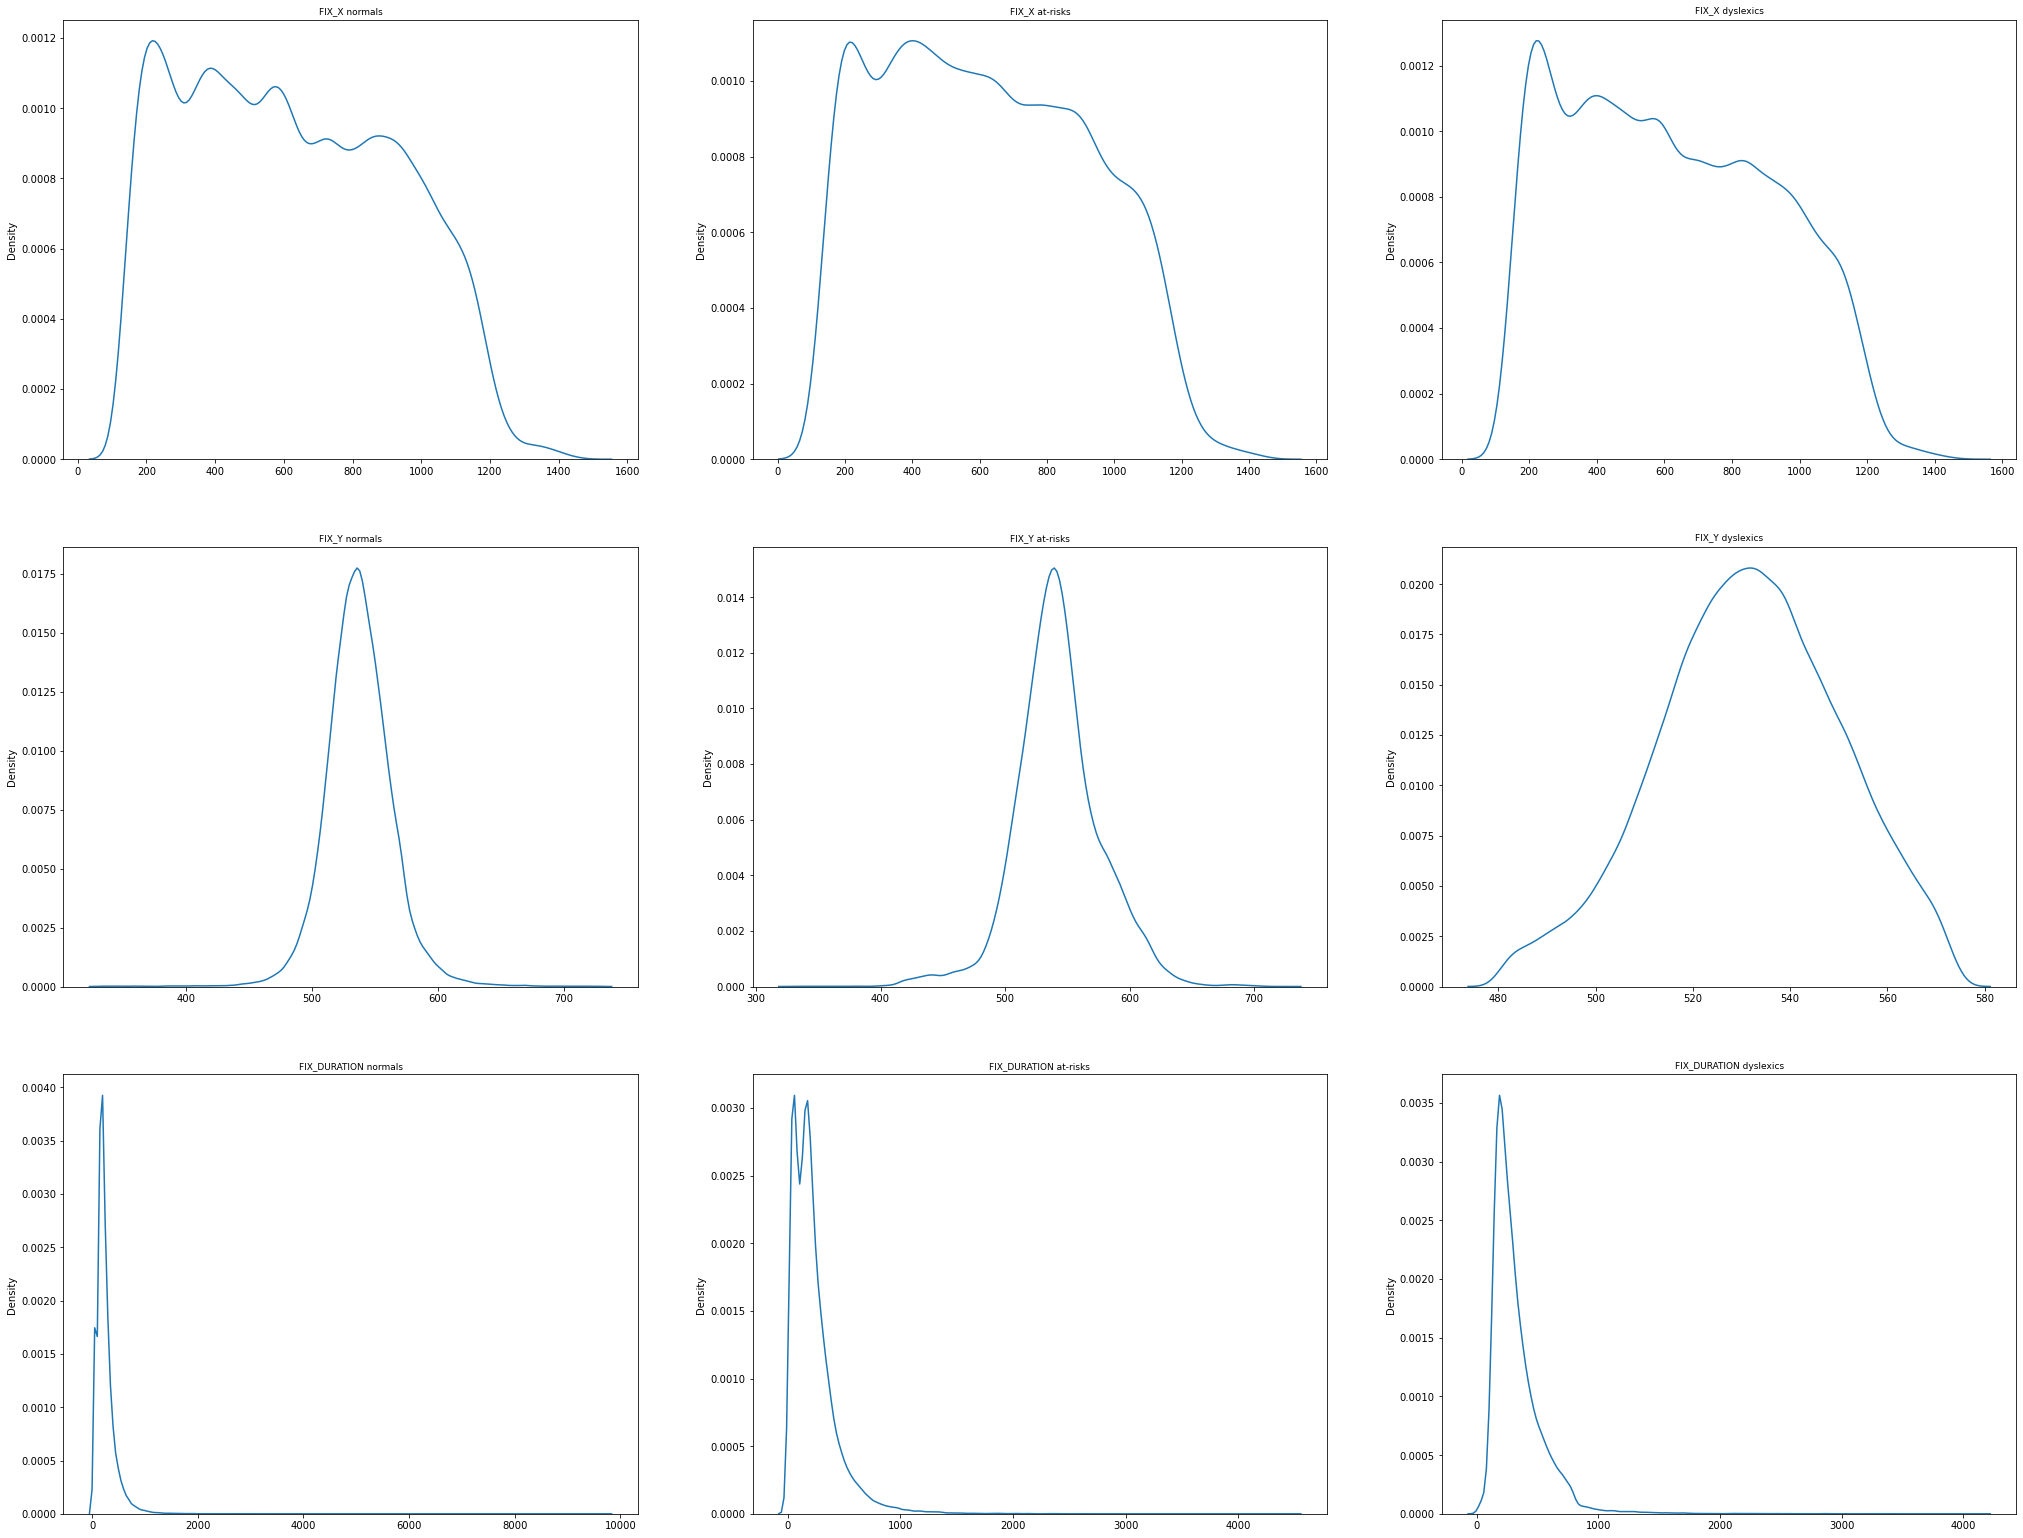

In [108]:


fig = plt.figure(figsize=(35, 25))
fig.subplots_adjust(bottom=0.05)


# FIX_X
ax = fig.add_subplot(3, 3, 1)  
sns.kdeplot(gx_o_n.FIX_X.values)
ax.set_title('FIX_X normals', fontsize=9)


ax = fig.add_subplot(3, 3, 2)  
sns.kdeplot(gx_o_r.FIX_X.values)
ax.set_title('FIX_X at-risks', fontsize=9)

ax = fig.add_subplot(3, 3, 3)  
sns.kdeplot(gx_o_d.FIX_X.values)
ax.set_title('FIX_X dyslexics', fontsize=9)


# FIX_Y
ax = fig.add_subplot(3, 3, 4)  
sns.kdeplot(gx_o_n.FIX_Y.values)
ax.set_title('FIX_Y normals', fontsize=9)


ax = fig.add_subplot(3, 3, 5)  
sns.kdeplot(gx_o_r.FIX_Y.values)
ax.set_title('FIX_Y at-risks', fontsize=9)

ax = fig.add_subplot(3, 3, 6)  
sns.kdeplot(gx_o_d.FIX_Y.values)
ax.set_title('FIX_Y dyslexics', fontsize=9)

# FIX_DURATION
ax = fig.add_subplot(3, 3, 7)  
sns.kdeplot(gx_o_n.FIX_DURATION.values)
ax.set_title('FIX_DURATION normals', fontsize=9)


ax = fig.add_subplot(3, 3, 8)  
sns.kdeplot(gx_o_r.FIX_DURATION.values)
ax.set_title('FIX_DURATION at-risks', fontsize=9)

ax = fig.add_subplot(3, 3, 9)  
sns.kdeplot(gx_o_d.FIX_DURATION.values)
ax.set_title('FIX_DURATION dyslexics', fontsize=9)



plt.show()


In [109]:


g1_o_n = fix_demo.loc[(fix_demo.Grade==1) & (fix_demo.Group==1)]
g1_o_r = fix_demo.loc[(fix_demo.Grade==1) & (fix_demo.Group==2)]
g1_o_d = fix_demo.loc[(fix_demo.Grade==1) & (fix_demo.Group==3)]

g2_o_n = fix_demo.loc[(fix_demo.Grade==2) & (fix_demo.Group==1)]
g2_o_r = fix_demo.loc[(fix_demo.Grade==2) & (fix_demo.Group==2)]
g2_o_d = fix_demo.loc[(fix_demo.Grade==2) & (fix_demo.Group==3)]


g3_o_n = fix_demo.loc[(fix_demo.Grade==3) & (fix_demo.Group==1)]
g3_o_r = fix_demo.loc[(fix_demo.Grade==3) & (fix_demo.Group==2)]
g3_o_d = fix_demo.loc[(fix_demo.Grade==3) & (fix_demo.Group==3)]


g4_o_n = fix_demo.loc[(fix_demo.Grade==4) & (fix_demo.Group==1)]
g4_o_r = fix_demo.loc[(fix_demo.Grade==4) & (fix_demo.Group==2)]
g4_o_d = fix_demo.loc[(fix_demo.Grade==4) & (fix_demo.Group==3)]

g5_o_n = fix_demo.loc[(fix_demo.Grade==5) & (fix_demo.Group==1)]
g5_o_r = fix_demo.loc[(fix_demo.Grade==5) & (fix_demo.Group==2)]
g5_o_d = fix_demo.loc[(fix_demo.Grade==5) & (fix_demo.Group==3)]


g6_o_n = fix_demo.loc[(fix_demo.Grade==6) & (fix_demo.Group==1)]
g6_o_r = fix_demo.loc[(fix_demo.Grade==6) & (fix_demo.Group==2)]
g6_o_d = fix_demo.loc[(fix_demo.Grade==6) & (fix_demo.Group==3)]





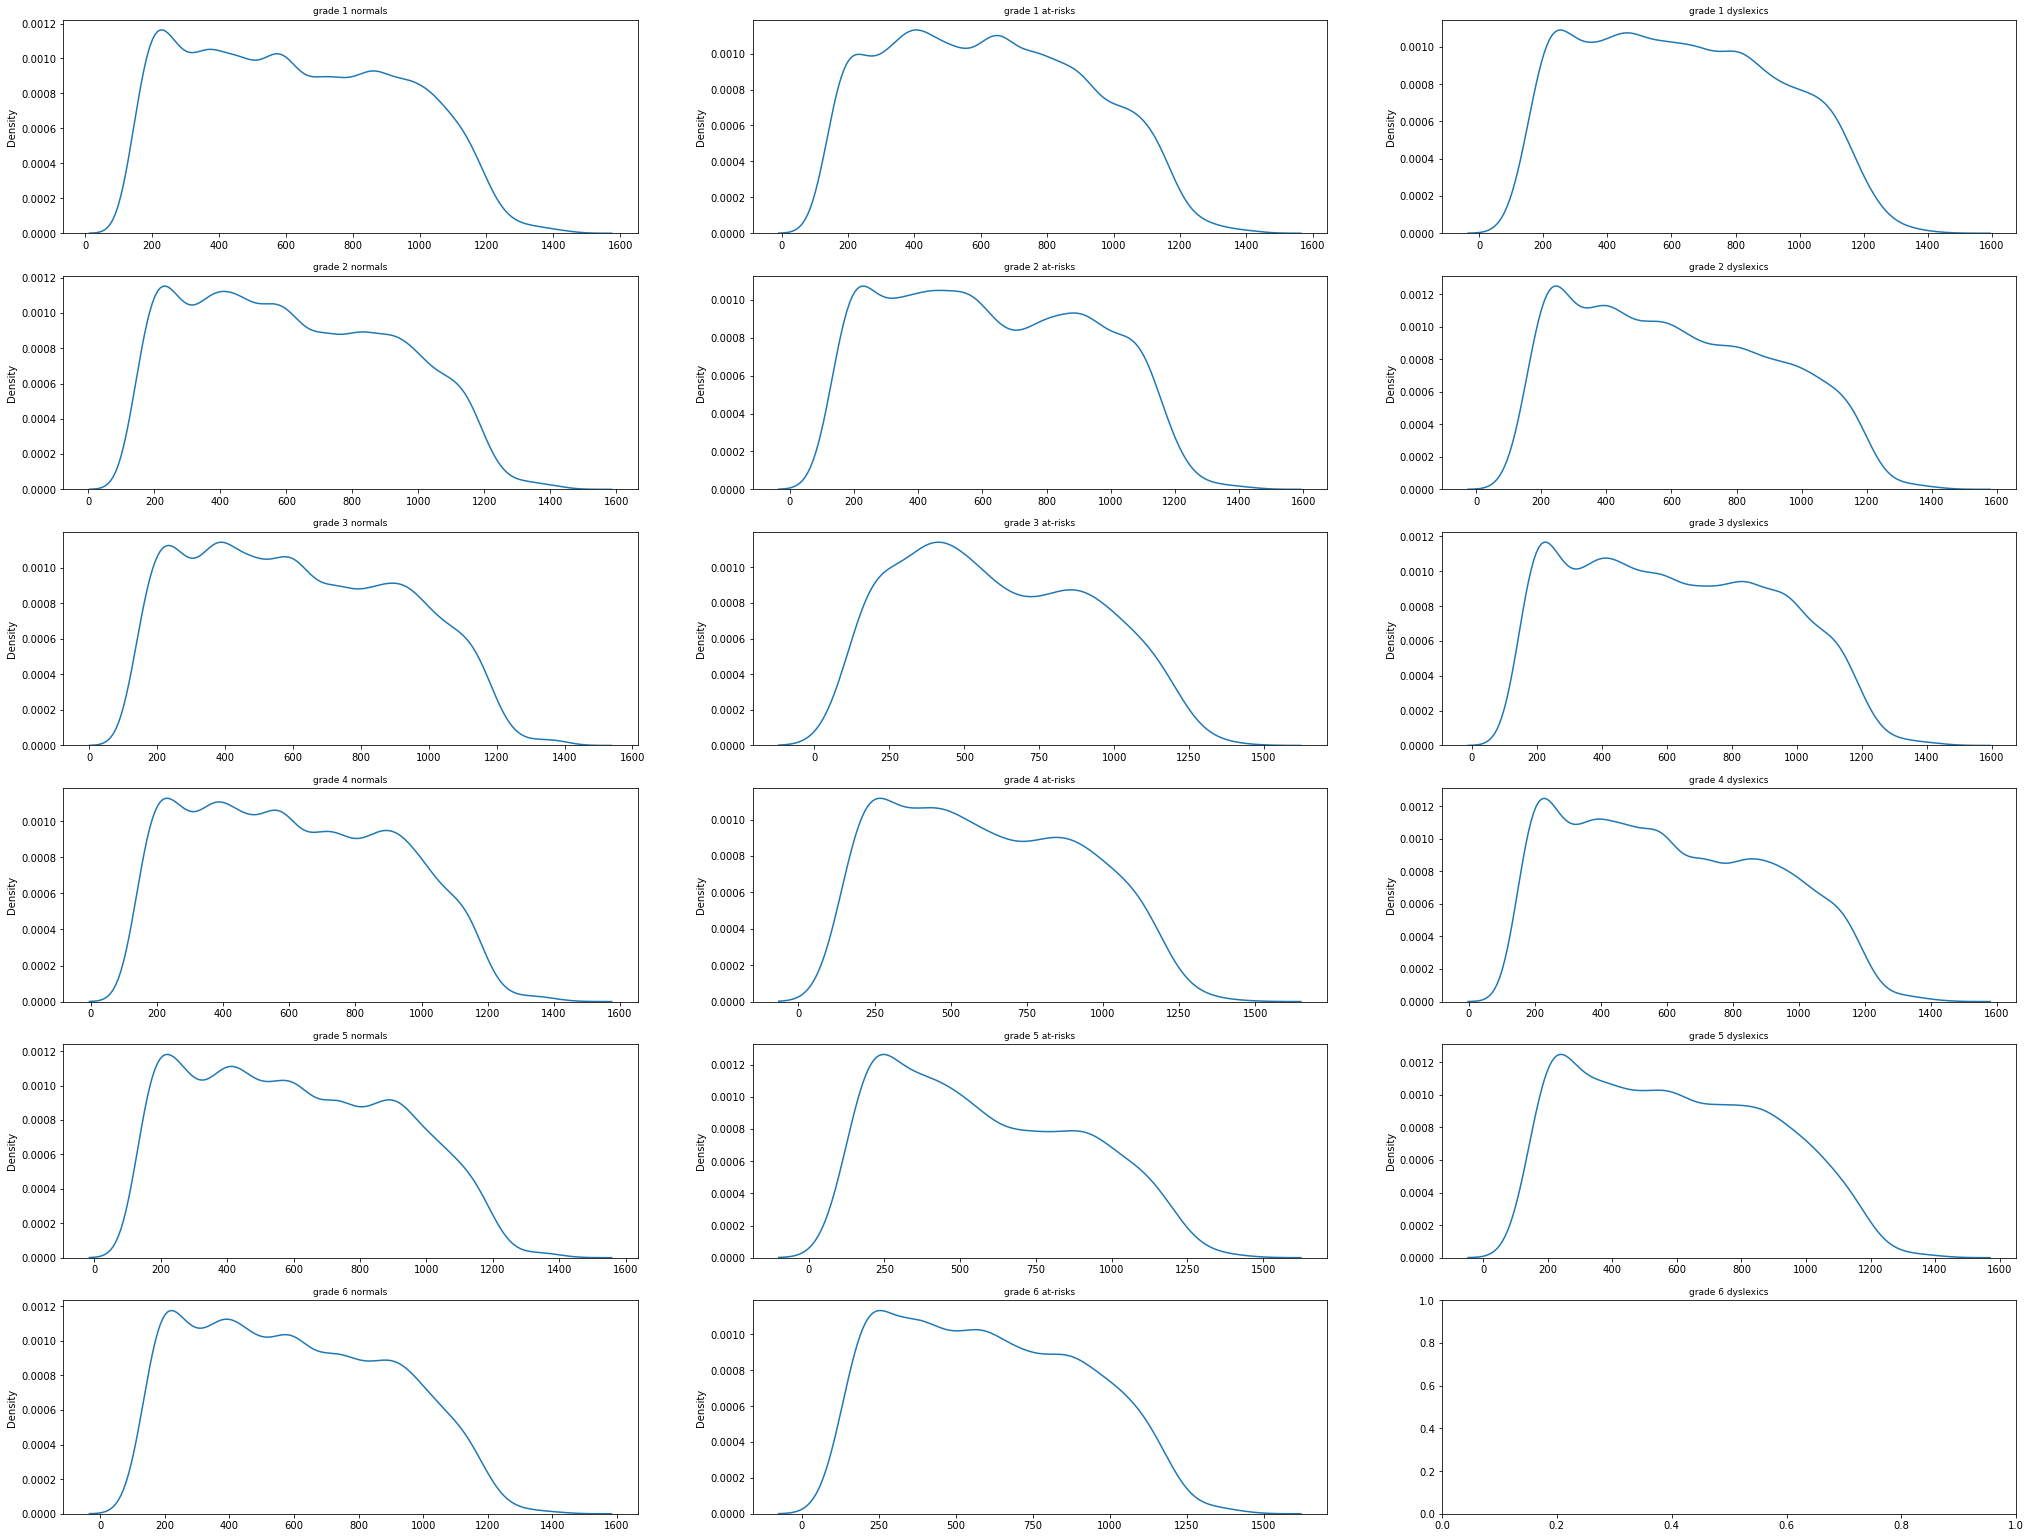

In [110]:

fig = plt.figure(figsize=(35, 25))
fig.subplots_adjust(bottom=0.05)


# grade 1
ax = fig.add_subplot(6, 3, 1)  
sns.kdeplot(g1_o_n.FIX_X.values)
ax.set_title('grade 1 normals', fontsize=9)


ax = fig.add_subplot(6, 3, 2)  
sns.kdeplot(g1_o_r.FIX_X.values)
ax.set_title('grade 1 at-risks', fontsize=9)

ax = fig.add_subplot(6, 3, 3)  
sns.kdeplot(g1_o_d.FIX_X.values)
ax.set_title('grade 1 dyslexics', fontsize=9)

# grade 2
ax = fig.add_subplot(6, 3, 4)  
sns.kdeplot(g2_o_n.FIX_X.values)
ax.set_title('grade 2 normals', fontsize=9)


ax = fig.add_subplot(6, 3, 5)  
sns.kdeplot(g2_o_r.FIX_X.values)
ax.set_title('grade 2 at-risks', fontsize=9)

ax = fig.add_subplot(6, 3, 6)  
sns.kdeplot(g2_o_d.FIX_X.values)
ax.set_title('grade 2 dyslexics', fontsize=9)


# grade 3
ax = fig.add_subplot(6, 3, 7)  
sns.kdeplot(g3_o_n.FIX_X.values)
ax.set_title('grade 3 normals', fontsize=9)


ax = fig.add_subplot(6, 3, 8)  
sns.kdeplot(g3_o_r.FIX_X.values)
ax.set_title('grade 3 at-risks', fontsize=9)

ax = fig.add_subplot(6, 3, 9)  
sns.kdeplot(g3_o_d.FIX_X.values)
ax.set_title('grade 3 dyslexics', fontsize=9)

# grade 4
ax = fig.add_subplot(6, 3, 10)  
sns.kdeplot(g4_o_n.FIX_X.values)
ax.set_title('grade 4 normals', fontsize=9)


ax = fig.add_subplot(6, 3, 11)  
sns.kdeplot(g4_o_r.FIX_X.values)
ax.set_title('grade 4 at-risks', fontsize=9)

ax = fig.add_subplot(6, 3, 12)  
sns.kdeplot(g4_o_d.FIX_X.values)
ax.set_title('grade 4 dyslexics', fontsize=9)


# grade 5
ax = fig.add_subplot(6, 3, 13)  
sns.kdeplot(g5_o_n.FIX_X.values)
ax.set_title('grade 5 normals', fontsize=9)


ax = fig.add_subplot(6, 3, 14)  
sns.kdeplot(g5_o_r.FIX_X.values)
ax.set_title('grade 5 at-risks', fontsize=9)

ax = fig.add_subplot(6, 3, 15)  
sns.kdeplot(g5_o_d.FIX_X.values)
ax.set_title('grade 5 dyslexics', fontsize=9)



# grade 6
ax = fig.add_subplot(6, 3, 16)  
sns.kdeplot(g6_o_n.FIX_X.values)
ax.set_title('grade 6 normals', fontsize=9)


ax = fig.add_subplot(6, 3, 17)  
sns.kdeplot(g6_o_r.FIX_X.values)
ax.set_title('grade 6 at-risks', fontsize=9)

ax = fig.add_subplot(6, 3, 18)  
sns.kdeplot(g6_o_d.FIX_X.values)
ax.set_title('grade 6 dyslexics', fontsize=9)

plt.show()





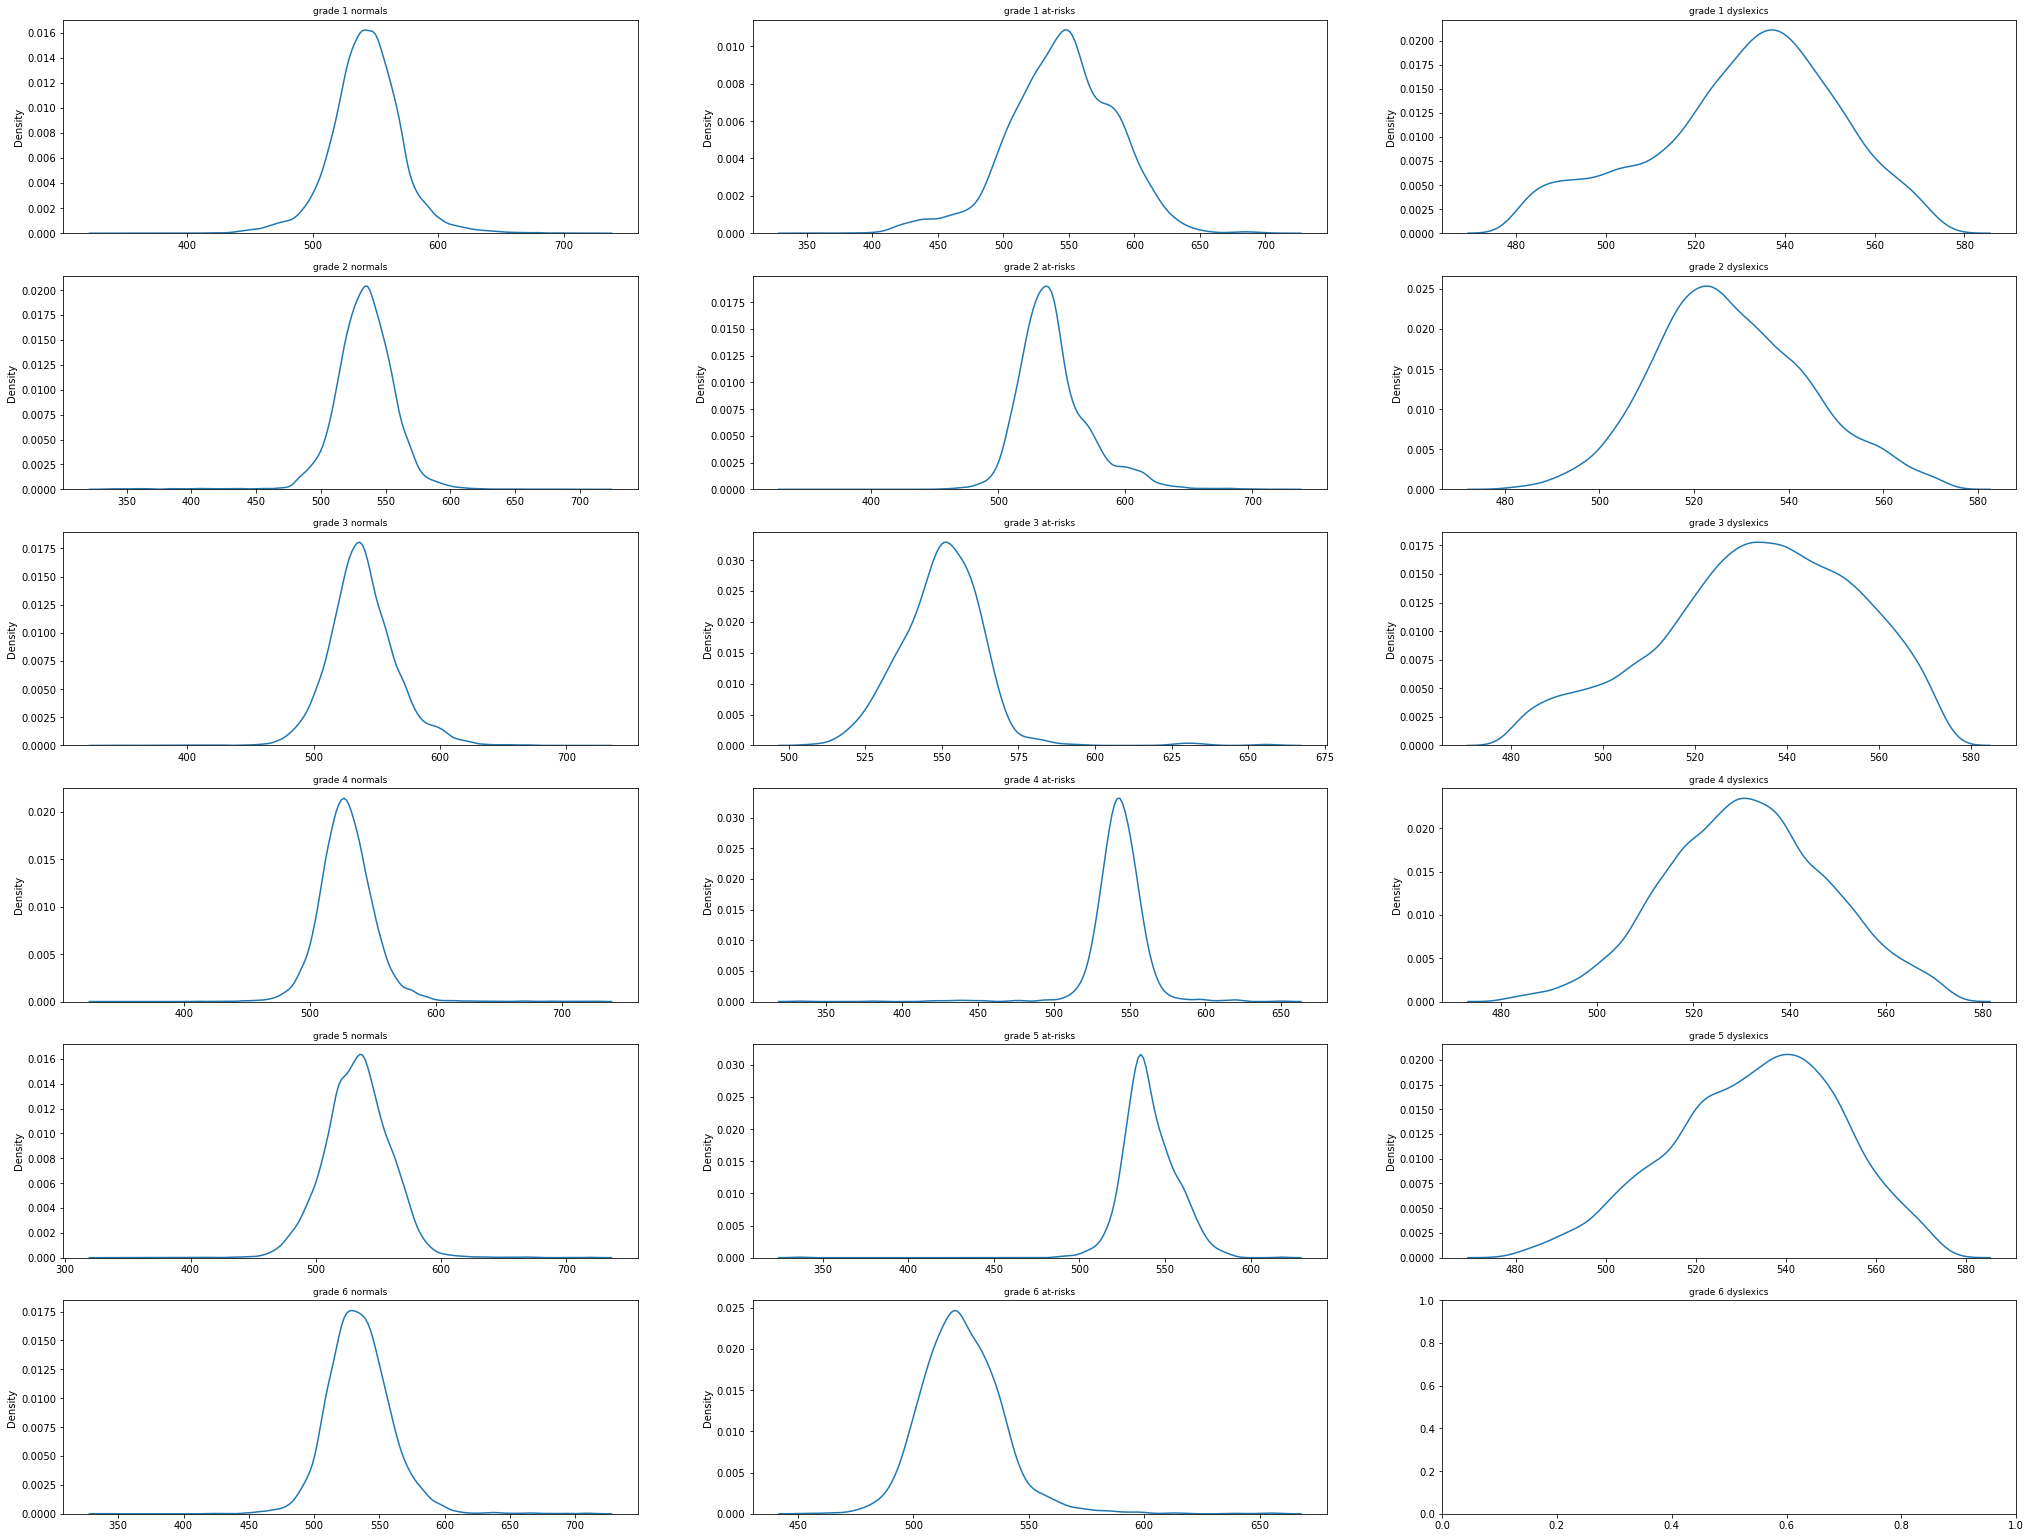

In [111]:



fig = plt.figure(figsize=(35, 25))
fig.subplots_adjust(bottom=0.05)


# grade 1
ax = fig.add_subplot(6, 3, 1)  
sns.kdeplot(g1_o_n.FIX_Y.values)
ax.set_title('grade 1 normals', fontsize=9)


ax = fig.add_subplot(6, 3, 2)  
sns.kdeplot(g1_o_r.FIX_Y.values)
ax.set_title('grade 1 at-risks', fontsize=9)

ax = fig.add_subplot(6, 3, 3)  
sns.kdeplot(g1_o_d.FIX_Y.values)
ax.set_title('grade 1 dyslexics', fontsize=9)

# grade 2
ax = fig.add_subplot(6, 3, 4)  
sns.kdeplot(g2_o_n.FIX_Y.values)
ax.set_title('grade 2 normals', fontsize=9)


ax = fig.add_subplot(6, 3, 5)  
sns.kdeplot(g2_o_r.FIX_Y.values)
ax.set_title('grade 2 at-risks', fontsize=9)

ax = fig.add_subplot(6, 3, 6)  
sns.kdeplot(g2_o_d.FIX_Y.values)
ax.set_title('grade 2 dyslexics', fontsize=9)


# grade 3
ax = fig.add_subplot(6, 3, 7)  
sns.kdeplot(g3_o_n.FIX_Y.values)
ax.set_title('grade 3 normals', fontsize=9)


ax = fig.add_subplot(6, 3, 8)  
sns.kdeplot(g3_o_r.FIX_Y.values)
ax.set_title('grade 3 at-risks', fontsize=9)

ax = fig.add_subplot(6, 3, 9)  
sns.kdeplot(g3_o_d.FIX_Y.values)
ax.set_title('grade 3 dyslexics', fontsize=9)

# grade 4
ax = fig.add_subplot(6, 3, 10)  
sns.kdeplot(g4_o_n.FIX_Y.values)
ax.set_title('grade 4 normals', fontsize=9)


ax = fig.add_subplot(6, 3, 11)  
sns.kdeplot(g4_o_r.FIX_Y.values)
ax.set_title('grade 4 at-risks', fontsize=9)

ax = fig.add_subplot(6, 3, 12)  
sns.kdeplot(g4_o_d.FIX_Y.values)
ax.set_title('grade 4 dyslexics', fontsize=9)


# grade 5
ax = fig.add_subplot(6, 3, 13)  
sns.kdeplot(g5_o_n.FIX_Y.values)
ax.set_title('grade 5 normals', fontsize=9)


ax = fig.add_subplot(6, 3, 14)  
sns.kdeplot(g5_o_r.FIX_Y.values)
ax.set_title('grade 5 at-risks', fontsize=9)

ax = fig.add_subplot(6, 3, 15)  
sns.kdeplot(g5_o_d.FIX_Y.values)
ax.set_title('grade 5 dyslexics', fontsize=9)



# grade 6
ax = fig.add_subplot(6, 3, 16)  
sns.kdeplot(g6_o_n.FIX_Y.values)
ax.set_title('grade 6 normals', fontsize=9)


ax = fig.add_subplot(6, 3, 17)  
sns.kdeplot(g6_o_r.FIX_Y.values)
ax.set_title('grade 6 at-risks', fontsize=9)

ax = fig.add_subplot(6, 3, 18)  
sns.kdeplot(g6_o_d.FIX_Y.values)
ax.set_title('grade 6 dyslexics', fontsize=9)

plt.show()





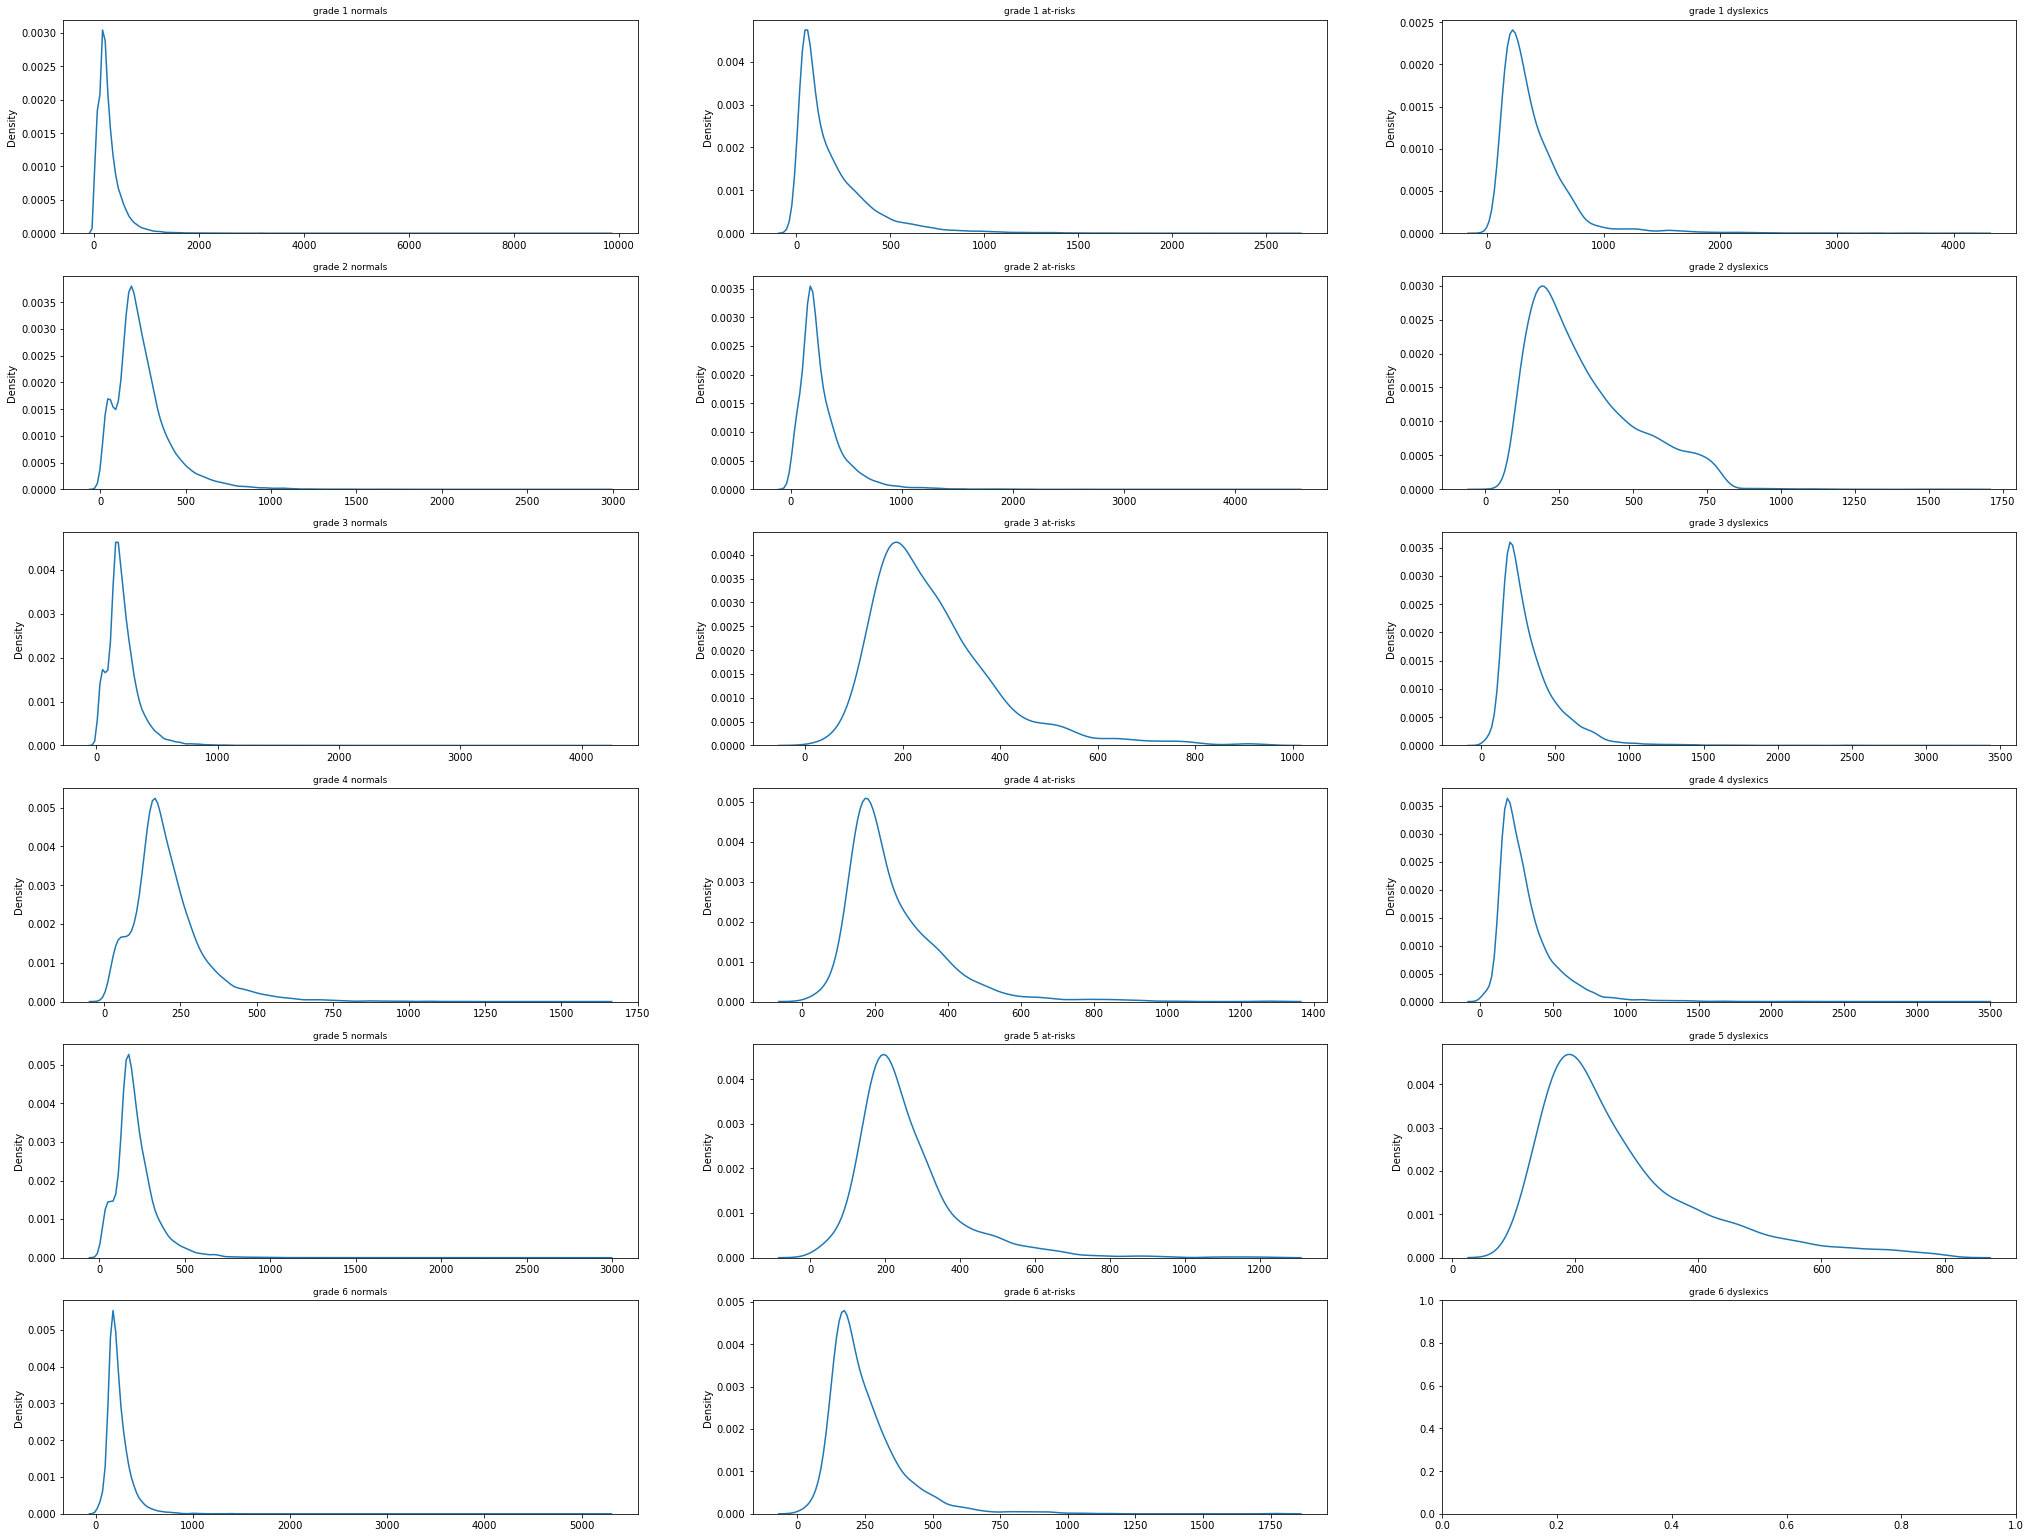

In [112]:



fig = plt.figure(figsize=(35, 25))
fig.subplots_adjust(bottom=0.05)


# grade 1
ax = fig.add_subplot(6, 3, 1)  
sns.kdeplot(g1_o_n.FIX_DURATION.values)
ax.set_title('grade 1 normals', fontsize=9)


ax = fig.add_subplot(6, 3, 2)  
sns.kdeplot(g1_o_r.FIX_DURATION.values)
ax.set_title('grade 1 at-risks', fontsize=9)

ax = fig.add_subplot(6, 3, 3)  
sns.kdeplot(g1_o_d.FIX_DURATION.values)
ax.set_title('grade 1 dyslexics', fontsize=9)

# grade 2
ax = fig.add_subplot(6, 3, 4)  
sns.kdeplot(g2_o_n.FIX_DURATION.values)
ax.set_title('grade 2 normals', fontsize=9)


ax = fig.add_subplot(6, 3, 5)  
sns.kdeplot(g2_o_r.FIX_DURATION.values)
ax.set_title('grade 2 at-risks', fontsize=9)

ax = fig.add_subplot(6, 3, 6)  
sns.kdeplot(g2_o_d.FIX_DURATION.values)
ax.set_title('grade 2 dyslexics', fontsize=9)


# grade 3
ax = fig.add_subplot(6, 3, 7)  
sns.kdeplot(g3_o_n.FIX_DURATION.values)
ax.set_title('grade 3 normals', fontsize=9)


ax = fig.add_subplot(6, 3, 8)  
sns.kdeplot(g3_o_r.FIX_DURATION.values)
ax.set_title('grade 3 at-risks', fontsize=9)

ax = fig.add_subplot(6, 3, 9)  
sns.kdeplot(g3_o_d.FIX_DURATION.values)
ax.set_title('grade 3 dyslexics', fontsize=9)

# grade 4
ax = fig.add_subplot(6, 3, 10)  
sns.kdeplot(g4_o_n.FIX_DURATION.values)
ax.set_title('grade 4 normals', fontsize=9)


ax = fig.add_subplot(6, 3, 11)  
sns.kdeplot(g4_o_r.FIX_DURATION.values)
ax.set_title('grade 4 at-risks', fontsize=9)

ax = fig.add_subplot(6, 3, 12)  
sns.kdeplot(g4_o_d.FIX_DURATION.values)
ax.set_title('grade 4 dyslexics', fontsize=9)


# grade 5
ax = fig.add_subplot(6, 3, 13)  
sns.kdeplot(g5_o_n.FIX_DURATION.values)
ax.set_title('grade 5 normals', fontsize=9)


ax = fig.add_subplot(6, 3, 14)  
sns.kdeplot(g5_o_r.FIX_DURATION.values)
ax.set_title('grade 5 at-risks', fontsize=9)

ax = fig.add_subplot(6, 3, 15)  
sns.kdeplot(g5_o_d.FIX_DURATION.values)
ax.set_title('grade 5 dyslexics', fontsize=9)



# grade 6
ax = fig.add_subplot(6, 3, 16)  
sns.kdeplot(g6_o_n.FIX_DURATION.values)
ax.set_title('grade 6 normals', fontsize=9)


ax = fig.add_subplot(6, 3, 17)  
sns.kdeplot(g6_o_r.FIX_DURATION.values)
ax.set_title('grade 6 at-risks', fontsize=9)

ax = fig.add_subplot(6, 3, 18)  
sns.kdeplot(g6_o_d.FIX_DURATION.values)
ax.set_title('grade 6 dyslexics', fontsize=9)

plt.show()





In [113]:




g1_o_n_f = fix_demo.loc[(fix_demo.Grade==1) & (fix_demo.Group==1) & (fix_demo.Sex==1)]
g1_o_n_m = fix_demo.loc[(fix_demo.Grade==1) & (fix_demo.Group==1) & (fix_demo.Sex==2)]
g1_o_r_f = fix_demo.loc[(fix_demo.Grade==1) & (fix_demo.Group==2) & (fix_demo.Sex==1)]
g1_o_r_m = fix_demo.loc[(fix_demo.Grade==1) & (fix_demo.Group==2) & (fix_demo.Sex==2)]
g1_o_d_f = fix_demo.loc[(fix_demo.Grade==1) & (fix_demo.Group==3) & (fix_demo.Sex==1)]
g1_o_d_m = fix_demo.loc[(fix_demo.Grade==1) & (fix_demo.Group==3) & (fix_demo.Sex==2)]


g2_o_n_f = fix_demo.loc[(fix_demo.Grade==2) & (fix_demo.Group==1) & (fix_demo.Sex==1)]
g2_o_n_m = fix_demo.loc[(fix_demo.Grade==2) & (fix_demo.Group==1) & (fix_demo.Sex==2)]
g2_o_r_f = fix_demo.loc[(fix_demo.Grade==2) & (fix_demo.Group==2) & (fix_demo.Sex==1)]
g2_o_r_m = fix_demo.loc[(fix_demo.Grade==2) & (fix_demo.Group==2) & (fix_demo.Sex==2)]
g2_o_d_f = fix_demo.loc[(fix_demo.Grade==2) & (fix_demo.Group==3) & (fix_demo.Sex==1)]
g2_o_d_m = fix_demo.loc[(fix_demo.Grade==2) & (fix_demo.Group==3) & (fix_demo.Sex==2)]



g3_o_n_f = fix_demo.loc[(fix_demo.Grade==3) & (fix_demo.Group==1) & (fix_demo.Sex==1)]
g3_o_n_m = fix_demo.loc[(fix_demo.Grade==3) & (fix_demo.Group==1) & (fix_demo.Sex==2)]
g3_o_r_f = fix_demo.loc[(fix_demo.Grade==3) & (fix_demo.Group==2) & (fix_demo.Sex==1)]
g3_o_r_m = fix_demo.loc[(fix_demo.Grade==3) & (fix_demo.Group==2) & (fix_demo.Sex==2)]
g3_o_d_f = fix_demo.loc[(fix_demo.Grade==3) & (fix_demo.Group==3) & (fix_demo.Sex==1)]
g3_o_d_m = fix_demo.loc[(fix_demo.Grade==3) & (fix_demo.Group==3) & (fix_demo.Sex==2)]


g4_o_n_f = fix_demo.loc[(fix_demo.Grade==4) & (fix_demo.Group==1) & (fix_demo.Sex==1)]
g4_o_n_m = fix_demo.loc[(fix_demo.Grade==4) & (fix_demo.Group==1) & (fix_demo.Sex==2)]
g4_o_r_f = fix_demo.loc[(fix_demo.Grade==4) & (fix_demo.Group==2) & (fix_demo.Sex==1)]
g4_o_r_m = fix_demo.loc[(fix_demo.Grade==4) & (fix_demo.Group==2) & (fix_demo.Sex==2)]
g4_o_d_f = fix_demo.loc[(fix_demo.Grade==4) & (fix_demo.Group==3) & (fix_demo.Sex==1)]
g4_o_d_m = fix_demo.loc[(fix_demo.Grade==4) & (fix_demo.Group==3) & (fix_demo.Sex==2)]


g5_o_n_f = fix_demo.loc[(fix_demo.Grade==5) & (fix_demo.Group==1) & (fix_demo.Sex==1)]
g5_o_n_m = fix_demo.loc[(fix_demo.Grade==5) & (fix_demo.Group==1) & (fix_demo.Sex==2)]
g5_o_r_f = fix_demo.loc[(fix_demo.Grade==5) & (fix_demo.Group==2) & (fix_demo.Sex==1)]
g5_o_r_m = fix_demo.loc[(fix_demo.Grade==5) & (fix_demo.Group==2) & (fix_demo.Sex==2)]
g5_o_d_f = fix_demo.loc[(fix_demo.Grade==5) & (fix_demo.Group==3) & (fix_demo.Sex==1)]
g5_o_d_m = fix_demo.loc[(fix_demo.Grade==5) & (fix_demo.Group==3) & (fix_demo.Sex==2)]


g6_o_n_f = fix_demo.loc[(fix_demo.Grade==6) & (fix_demo.Group==1) & (fix_demo.Sex==1)]
g6_o_n_m = fix_demo.loc[(fix_demo.Grade==6) & (fix_demo.Group==1) & (fix_demo.Sex==2)]
g6_o_r_f = fix_demo.loc[(fix_demo.Grade==6) & (fix_demo.Group==2) & (fix_demo.Sex==1)]
g6_o_r_m = fix_demo.loc[(fix_demo.Grade==6) & (fix_demo.Group==2) & (fix_demo.Sex==2)]
g6_o_d_f = fix_demo.loc[(fix_demo.Grade==6) & (fix_demo.Group==3) & (fix_demo.Sex==1)]
g6_o_d_m = fix_demo.loc[(fix_demo.Grade==6) & (fix_demo.Group==3) & (fix_demo.Sex==2)]





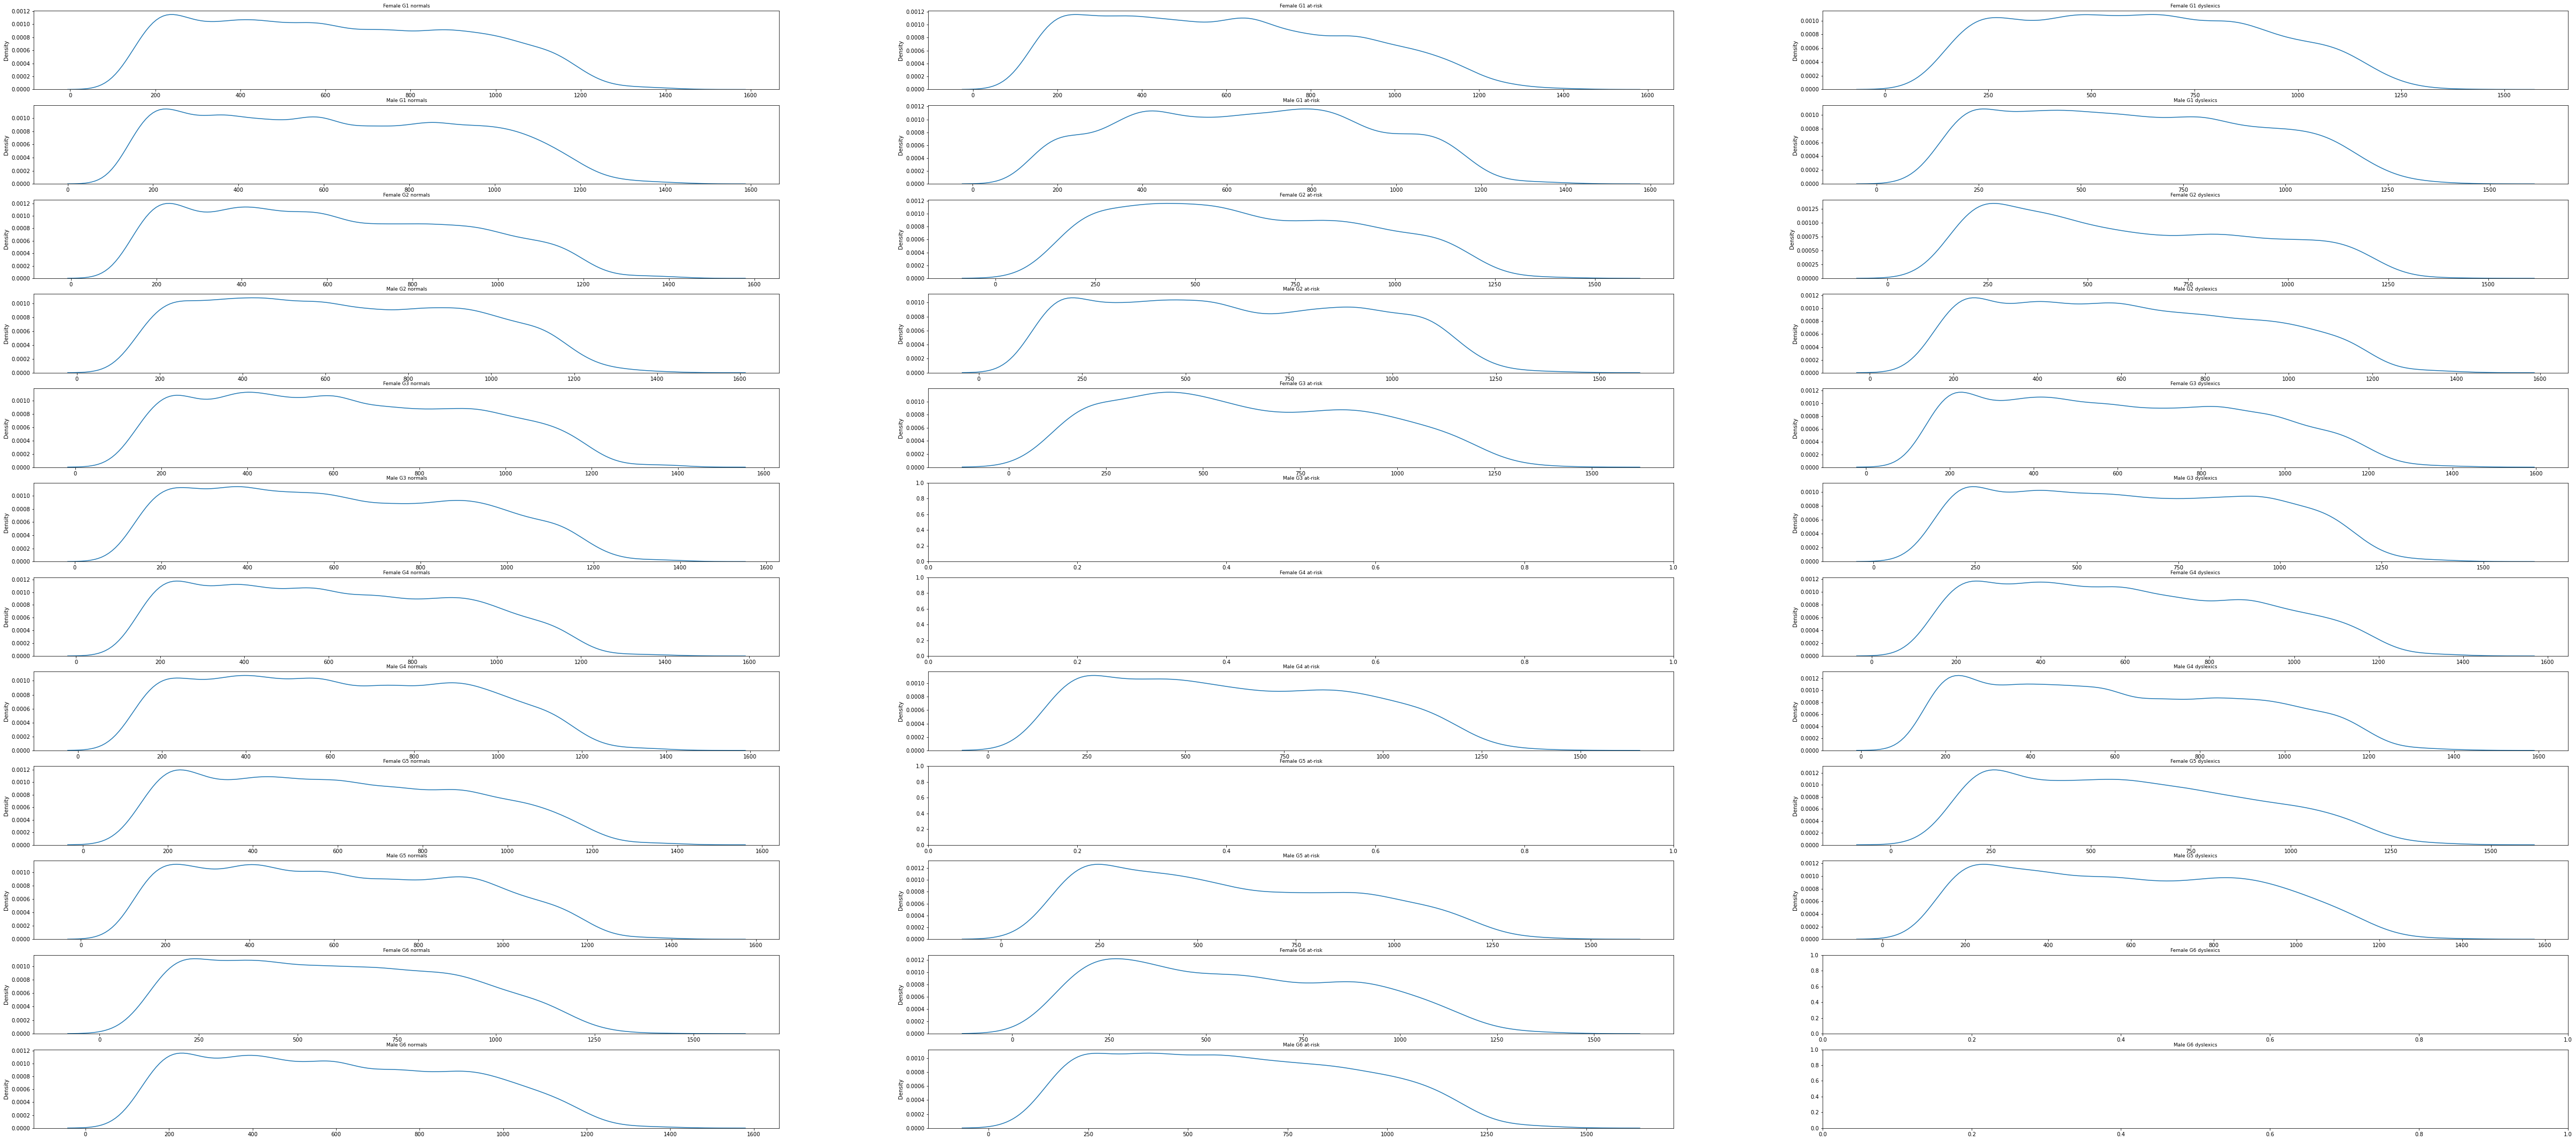

In [114]:

fig = plt.figure(figsize=(85, 35))
fig.subplots_adjust(bottom=0.05)


# grade 1 - Female
ax = fig.add_subplot(12, 3, 1)  
sns.kdeplot(g1_o_n_f.FIX_X.values)
ax.set_title('Female G1 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 2)  
sns.kdeplot(g1_o_r_f.FIX_X.values)
ax.set_title('Female G1 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 3)  
sns.kdeplot(g1_o_d_f.FIX_X.values)
ax.set_title('Female G1 dyslexics', fontsize=9)


# grade 1 - Male
ax = fig.add_subplot(12, 3, 4)  
sns.kdeplot(g1_o_n_m.FIX_X.values)
ax.set_title('Male G1 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 5)  
sns.kdeplot(g1_o_r_m.FIX_X.values)
ax.set_title('Male G1 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 6)  
sns.kdeplot(g1_o_d_m.FIX_X.values)
ax.set_title('Male G1 dyslexics', fontsize=9)


# grade 2 - Female
ax = fig.add_subplot(12, 3, 7)  
sns.kdeplot(g2_o_n_f.FIX_X.values)
ax.set_title('Female G2 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 8)  
sns.kdeplot(g2_o_r_f.FIX_X.values)
ax.set_title('Female G2 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 9)  
sns.kdeplot(g2_o_d_f.FIX_X.values)
ax.set_title('Female G2 dyslexics', fontsize=9)


# grade 2 - Male
ax = fig.add_subplot(12, 3, 10)  
sns.kdeplot(g2_o_n_m.FIX_X.values)
ax.set_title('Male G2 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 11)  
sns.kdeplot(g2_o_r_m.FIX_X.values)
ax.set_title('Male G2 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 12)  
sns.kdeplot(g2_o_d_m.FIX_X.values)
ax.set_title('Male G2 dyslexics', fontsize=9)


# grade 3 - Female
ax = fig.add_subplot(12, 3, 13)  
sns.kdeplot(g3_o_n_f.FIX_X.values)
ax.set_title('Female G3 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 14)  
sns.kdeplot(g3_o_r_f.FIX_X.values)
ax.set_title('Female G3 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 15)  
sns.kdeplot(g3_o_d_f.FIX_X.values)
ax.set_title('Female G3 dyslexics', fontsize=9)


# grade 3 - Male
ax = fig.add_subplot(12, 3, 16)  
sns.kdeplot(g3_o_n_m.FIX_X.values)
ax.set_title('Male G3 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 17)  
sns.kdeplot(g3_o_r_m.FIX_X.values)
ax.set_title('Male G3 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 18)  
sns.kdeplot(g3_o_d_m.FIX_X.values)
ax.set_title('Male G3 dyslexics', fontsize=9)

# grade 4 - Female
ax = fig.add_subplot(12, 3, 19)  
sns.kdeplot(g4_o_n_f.FIX_X.values)
ax.set_title('Female G4 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 20)  
sns.kdeplot(g4_o_r_f.FIX_X.values)
ax.set_title('Female G4 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 21)  
sns.kdeplot(g4_o_d_f.FIX_X.values)
ax.set_title('Female G4 dyslexics', fontsize=9)


# grade 4 - Male
ax = fig.add_subplot(12, 3, 22)  
sns.kdeplot(g4_o_n_m.FIX_X.values)
ax.set_title('Male G4 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 23)  
sns.kdeplot(g4_o_r_m.FIX_X.values)
ax.set_title('Male G4 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 24)  
sns.kdeplot(g4_o_d_m.FIX_X.values)
ax.set_title('Male G4 dyslexics', fontsize=9)


# grade 5 - Female
ax = fig.add_subplot(12, 3, 25)  
sns.kdeplot(g5_o_n_f.FIX_X.values)
ax.set_title('Female G5 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 26)  
sns.kdeplot(g5_o_r_f.FIX_X.values)
ax.set_title('Female G5 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 27)  
sns.kdeplot(g5_o_d_f.FIX_X.values)
ax.set_title('Female G5 dyslexics', fontsize=9)


# grade 5 - Male
ax = fig.add_subplot(12, 3, 28)  
sns.kdeplot(g5_o_n_m.FIX_X.values)
ax.set_title('Male G5 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 29)  
sns.kdeplot(g5_o_r_m.FIX_X.values)
ax.set_title('Male G5 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 30)  
sns.kdeplot(g5_o_d_m.FIX_X.values)
ax.set_title('Male G5 dyslexics', fontsize=9)


# grade 6 - Female
ax = fig.add_subplot(12, 3, 31)  
sns.kdeplot(g6_o_n_f.FIX_X.values)
ax.set_title('Female G6 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 32)  
sns.kdeplot(g6_o_r_f.FIX_X.values)
ax.set_title('Female G6 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 33)  
sns.kdeplot(g6_o_d_f.FIX_X.values)
ax.set_title('Female G6 dyslexics', fontsize=9)


# grade 6 - Male
ax = fig.add_subplot(12, 3, 34)  
sns.kdeplot(g6_o_n_m.FIX_X.values)
ax.set_title('Male G6 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 35)  
sns.kdeplot(g6_o_r_m.FIX_X.values)
ax.set_title('Male G6 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 36)  
sns.kdeplot(g6_o_d_m.FIX_X.values)
ax.set_title('Male G6 dyslexics', fontsize=9)


plt.show()



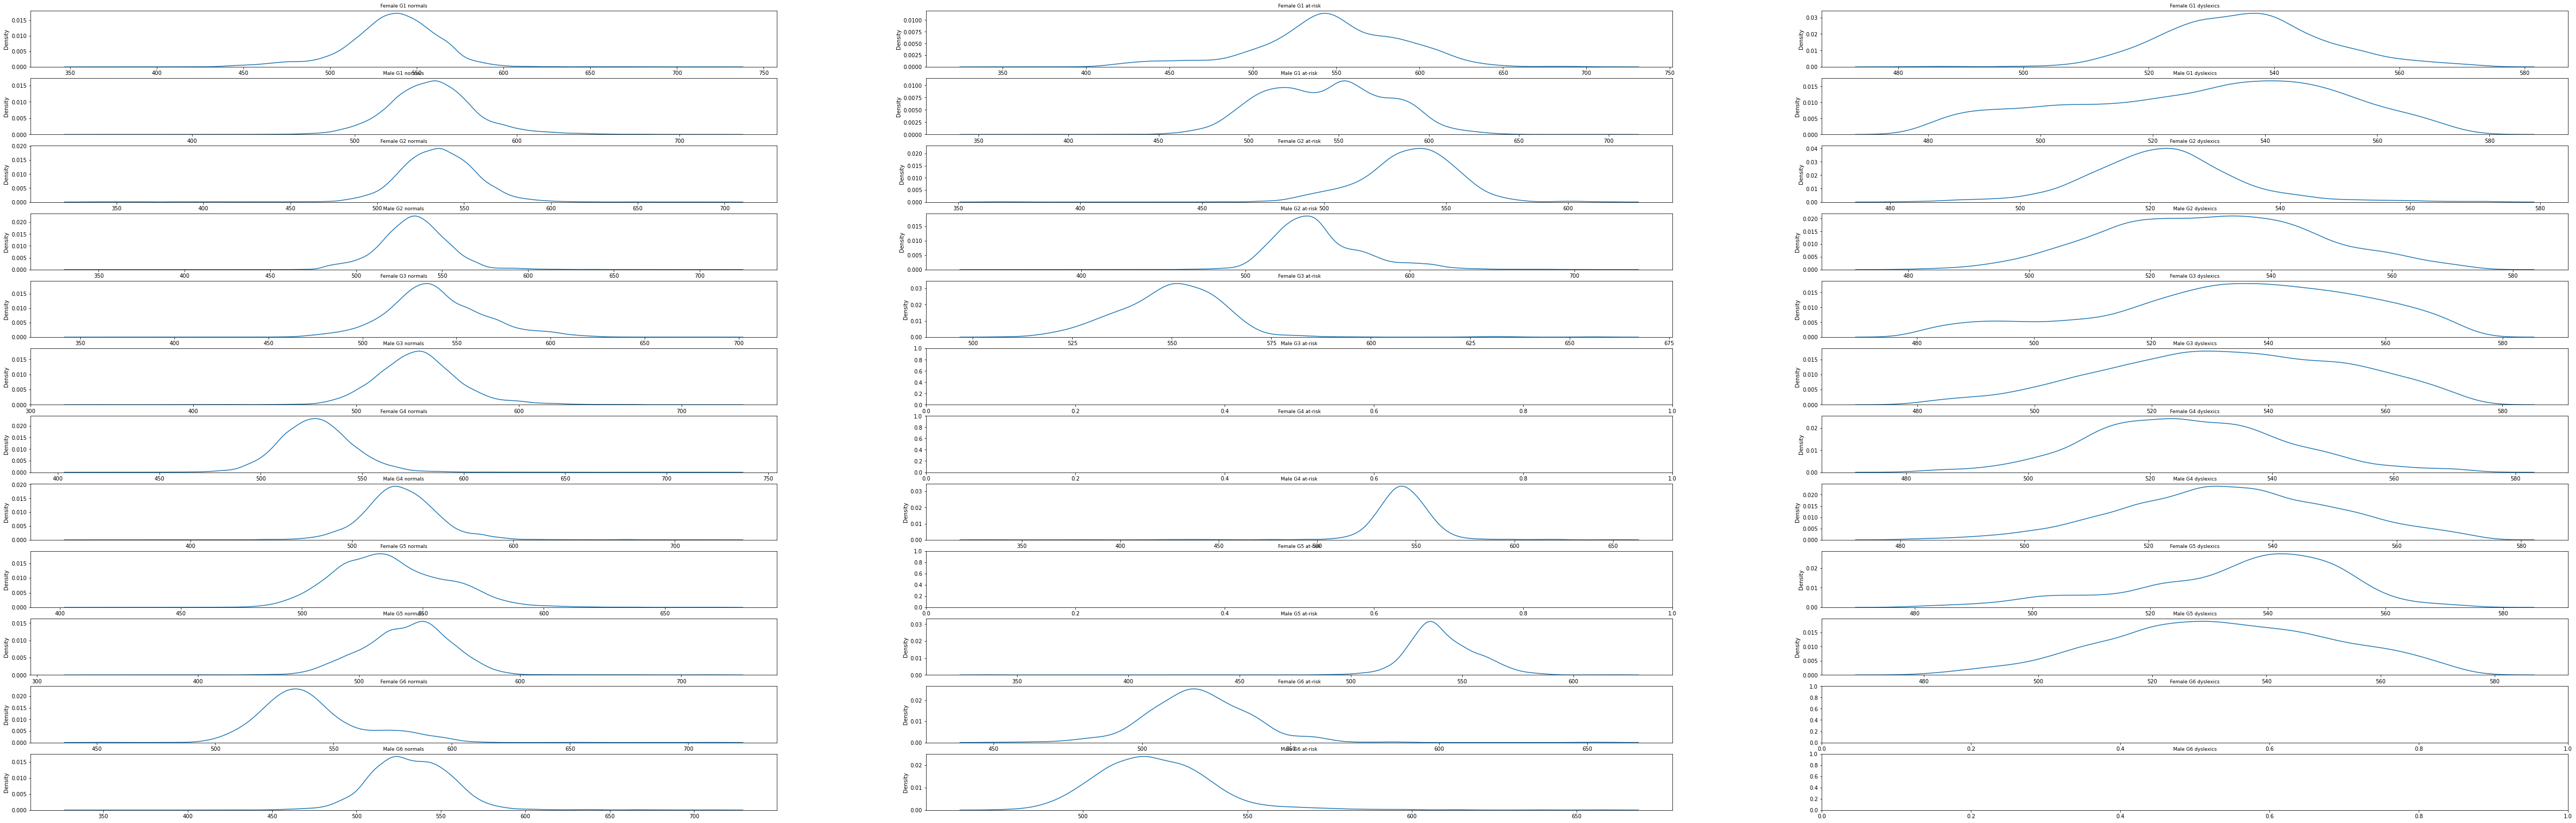

In [115]:



fig = plt.figure(figsize=(85, 25))
fig.subplots_adjust(bottom=0.05)


# grade 1 - Female
ax = fig.add_subplot(12, 3, 1)  
sns.kdeplot(g1_o_n_f.FIX_Y.values)
ax.set_title('Female G1 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 2)  
sns.kdeplot(g1_o_r_f.FIX_Y.values)
ax.set_title('Female G1 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 3)  
sns.kdeplot(g1_o_d_f.FIX_Y.values)
ax.set_title('Female G1 dyslexics', fontsize=9)


# grade 1 - Male
ax = fig.add_subplot(12, 3, 4)  
sns.kdeplot(g1_o_n_m.FIX_Y.values)
ax.set_title('Male G1 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 5)  
sns.kdeplot(g1_o_r_m.FIX_Y.values)
ax.set_title('Male G1 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 6)  
sns.kdeplot(g1_o_d_m.FIX_Y.values)
ax.set_title('Male G1 dyslexics', fontsize=9)


# grade 2 - Female
ax = fig.add_subplot(12, 3, 7)  
sns.kdeplot(g2_o_n_f.FIX_Y.values)
ax.set_title('Female G2 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 8)  
sns.kdeplot(g2_o_r_f.FIX_Y.values)
ax.set_title('Female G2 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 9)  
sns.kdeplot(g2_o_d_f.FIX_Y.values)
ax.set_title('Female G2 dyslexics', fontsize=9)


# grade 2 - Male
ax = fig.add_subplot(12, 3, 10)  
sns.kdeplot(g2_o_n_m.FIX_Y.values)
ax.set_title('Male G2 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 11)  
sns.kdeplot(g2_o_r_m.FIX_Y.values)
ax.set_title('Male G2 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 12)  
sns.kdeplot(g2_o_d_m.FIX_Y.values)
ax.set_title('Male G2 dyslexics', fontsize=9)


# grade 3 - Female
ax = fig.add_subplot(12, 3, 13)  
sns.kdeplot(g3_o_n_f.FIX_Y.values)
ax.set_title('Female G3 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 14)  
sns.kdeplot(g3_o_r_f.FIX_Y.values)
ax.set_title('Female G3 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 15)  
sns.kdeplot(g3_o_d_f.FIX_Y.values)
ax.set_title('Female G3 dyslexics', fontsize=9)


# grade 3 - Male
ax = fig.add_subplot(12, 3, 16)  
sns.kdeplot(g3_o_n_m.FIX_Y.values)
ax.set_title('Male G3 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 17)  
sns.kdeplot(g3_o_r_m.FIX_Y.values)
ax.set_title('Male G3 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 18)  
sns.kdeplot(g3_o_d_m.FIX_Y.values)
ax.set_title('Male G3 dyslexics', fontsize=9)

# grade 4 - Female
ax = fig.add_subplot(12, 3, 19)  
sns.kdeplot(g4_o_n_f.FIX_Y.values)
ax.set_title('Female G4 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 20)  
sns.kdeplot(g4_o_r_f.FIX_Y.values)
ax.set_title('Female G4 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 21)  
sns.kdeplot(g4_o_d_f.FIX_Y.values)
ax.set_title('Female G4 dyslexics', fontsize=9)


# grade 4 - Male
ax = fig.add_subplot(12, 3, 22)  
sns.kdeplot(g4_o_n_m.FIX_Y.values)
ax.set_title('Male G4 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 23)  
sns.kdeplot(g4_o_r_m.FIX_Y.values)
ax.set_title('Male G4 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 24)  
sns.kdeplot(g4_o_d_m.FIX_Y.values)
ax.set_title('Male G4 dyslexics', fontsize=9)


# grade 5 - Female
ax = fig.add_subplot(12, 3, 25)  
sns.kdeplot(g5_o_n_f.FIX_Y.values)
ax.set_title('Female G5 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 26)  
sns.kdeplot(g5_o_r_f.FIX_Y.values)
ax.set_title('Female G5 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 27)  
sns.kdeplot(g5_o_d_f.FIX_Y.values)
ax.set_title('Female G5 dyslexics', fontsize=9)


# grade 5 - Male
ax = fig.add_subplot(12, 3, 28)  
sns.kdeplot(g5_o_n_m.FIX_Y.values)
ax.set_title('Male G5 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 29)  
sns.kdeplot(g5_o_r_m.FIX_Y.values)
ax.set_title('Male G5 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 30)  
sns.kdeplot(g5_o_d_m.FIX_Y.values)
ax.set_title('Male G5 dyslexics', fontsize=9)


# grade 6 - Female
ax = fig.add_subplot(12, 3, 31)  
sns.kdeplot(g6_o_n_f.FIX_Y.values)
ax.set_title('Female G6 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 32)  
sns.kdeplot(g6_o_r_f.FIX_Y.values)
ax.set_title('Female G6 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 33)  
sns.kdeplot(g6_o_d_f.FIX_Y.values)
ax.set_title('Female G6 dyslexics', fontsize=9)


# grade 6 - Male
ax = fig.add_subplot(12, 3, 34)  
sns.kdeplot(g6_o_n_m.FIX_Y.values)
ax.set_title('Male G6 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 35)  
sns.kdeplot(g6_o_r_m.FIX_Y.values)
ax.set_title('Male G6 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 36)  
sns.kdeplot(g6_o_d_m.FIX_Y.values)
ax.set_title('Male G6 dyslexics', fontsize=9)




plt.show()

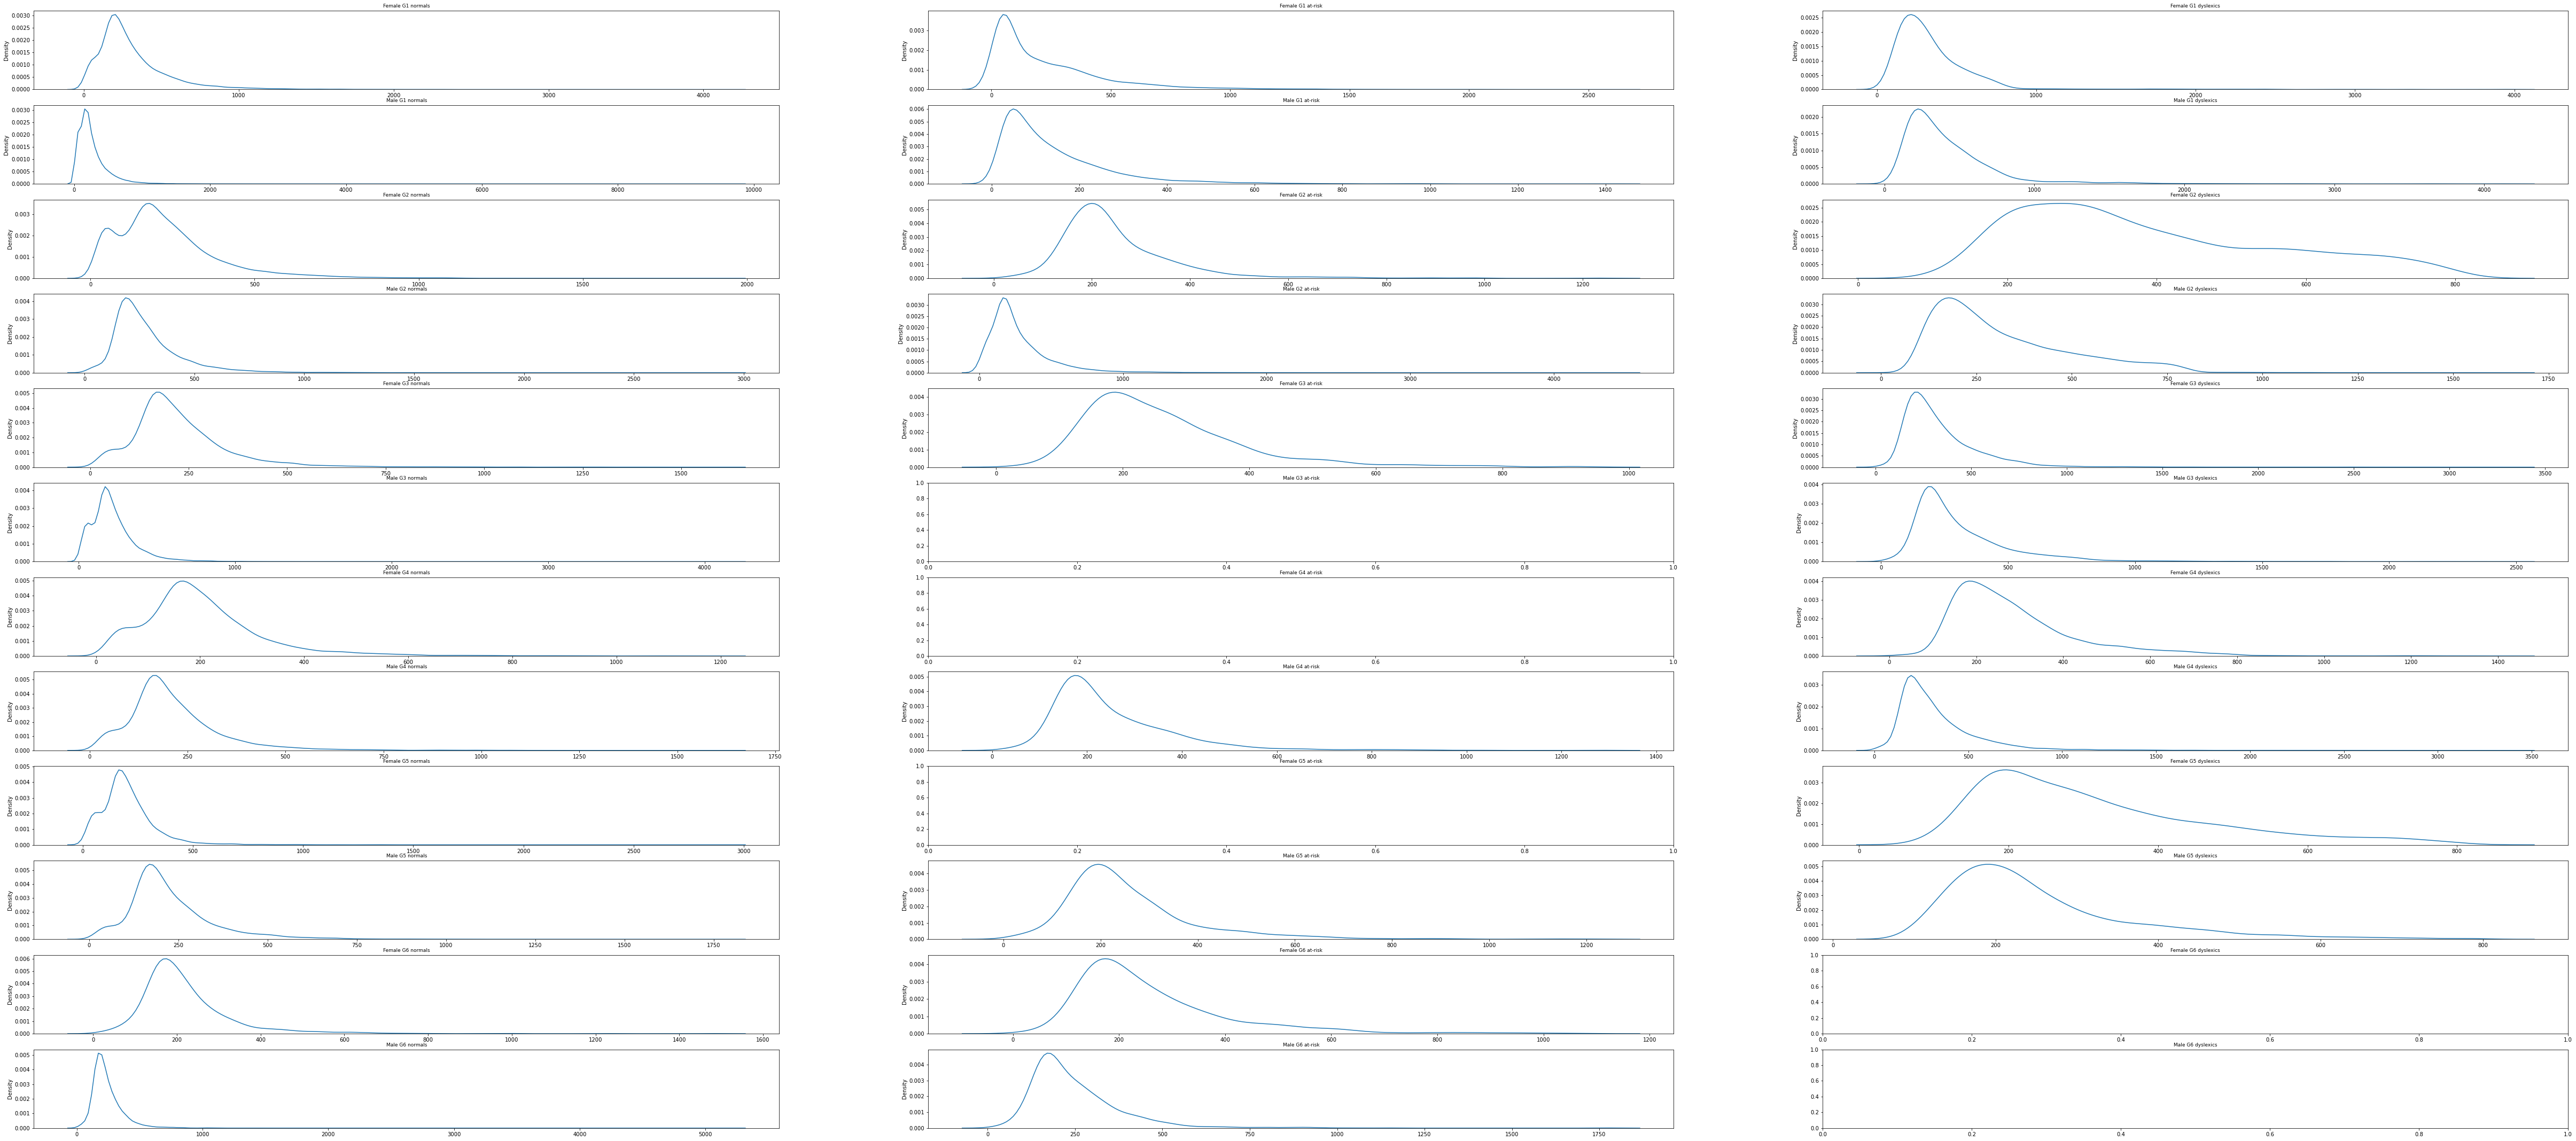

In [116]:



fig = plt.figure(figsize=(85, 35))
fig.subplots_adjust(bottom=0.05)


# grade 1 - Female
ax = fig.add_subplot(12, 3, 1)  
sns.kdeplot(g1_o_n_f.FIX_DURATION.values)
ax.set_title('Female G1 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 2)  
sns.kdeplot(g1_o_r_f.FIX_DURATION.values)
ax.set_title('Female G1 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 3)  
sns.kdeplot(g1_o_d_f.FIX_DURATION.values)
ax.set_title('Female G1 dyslexics', fontsize=9)


# grade 1 - Male
ax = fig.add_subplot(12, 3, 4)  
sns.kdeplot(g1_o_n_m.FIX_DURATION.values)
ax.set_title('Male G1 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 5)  
sns.kdeplot(g1_o_r_m.FIX_DURATION.values)
ax.set_title('Male G1 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 6)  
sns.kdeplot(g1_o_d_m.FIX_DURATION.values)
ax.set_title('Male G1 dyslexics', fontsize=9)


# grade 2 - Female
ax = fig.add_subplot(12, 3, 7)  
sns.kdeplot(g2_o_n_f.FIX_DURATION.values)
ax.set_title('Female G2 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 8)  
sns.kdeplot(g2_o_r_f.FIX_DURATION.values)
ax.set_title('Female G2 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 9)  
sns.kdeplot(g2_o_d_f.FIX_DURATION.values)
ax.set_title('Female G2 dyslexics', fontsize=9)


# grade 2 - Male
ax = fig.add_subplot(12, 3, 10)  
sns.kdeplot(g2_o_n_m.FIX_DURATION.values)
ax.set_title('Male G2 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 11)  
sns.kdeplot(g2_o_r_m.FIX_DURATION.values)
ax.set_title('Male G2 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 12)  
sns.kdeplot(g2_o_d_m.FIX_DURATION.values)
ax.set_title('Male G2 dyslexics', fontsize=9)


# grade 3 - Female
ax = fig.add_subplot(12, 3, 13)  
sns.kdeplot(g3_o_n_f.FIX_DURATION.values)
ax.set_title('Female G3 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 14)  
sns.kdeplot(g3_o_r_f.FIX_DURATION.values)
ax.set_title('Female G3 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 15)  
sns.kdeplot(g3_o_d_f.FIX_DURATION.values)
ax.set_title('Female G3 dyslexics', fontsize=9)


# grade 3 - Male
ax = fig.add_subplot(12, 3, 16)  
sns.kdeplot(g3_o_n_m.FIX_DURATION.values)
ax.set_title('Male G3 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 17)  
sns.kdeplot(g3_o_r_m.FIX_DURATION.values)
ax.set_title('Male G3 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 18)  
sns.kdeplot(g3_o_d_m.FIX_DURATION.values)
ax.set_title('Male G3 dyslexics', fontsize=9)

# grade 4 - Female
ax = fig.add_subplot(12, 3, 19)  
sns.kdeplot(g4_o_n_f.FIX_DURATION.values)
ax.set_title('Female G4 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 20)  
sns.kdeplot(g4_o_r_f.FIX_DURATION.values)
ax.set_title('Female G4 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 21)  
sns.kdeplot(g4_o_d_f.FIX_DURATION.values)
ax.set_title('Female G4 dyslexics', fontsize=9)


# grade 4 - Male
ax = fig.add_subplot(12, 3, 22)  
sns.kdeplot(g4_o_n_m.FIX_DURATION.values)
ax.set_title('Male G4 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 23)  
sns.kdeplot(g4_o_r_m.FIX_DURATION.values)
ax.set_title('Male G4 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 24)  
sns.kdeplot(g4_o_d_m.FIX_DURATION.values)
ax.set_title('Male G4 dyslexics', fontsize=9)


# grade 5 - Female
ax = fig.add_subplot(12, 3, 25)  
sns.kdeplot(g5_o_n_f.FIX_DURATION.values)
ax.set_title('Female G5 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 26)  
sns.kdeplot(g5_o_r_f.FIX_DURATION.values)
ax.set_title('Female G5 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 27)  
sns.kdeplot(g5_o_d_f.FIX_DURATION.values)
ax.set_title('Female G5 dyslexics', fontsize=9)


# grade 5 - Male
ax = fig.add_subplot(12, 3, 28)  
sns.kdeplot(g5_o_n_m.FIX_DURATION.values)
ax.set_title('Male G5 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 29)  
sns.kdeplot(g5_o_r_m.FIX_DURATION.values)
ax.set_title('Male G5 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 30)  
sns.kdeplot(g5_o_d_m.FIX_DURATION.values)
ax.set_title('Male G5 dyslexics', fontsize=9)


# grade 6 - Female
ax = fig.add_subplot(12, 3, 31)  
sns.kdeplot(g6_o_n_f.FIX_DURATION.values)
ax.set_title('Female G6 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 32)  
sns.kdeplot(g6_o_r_f.FIX_DURATION.values)
ax.set_title('Female G6 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 33)  
sns.kdeplot(g6_o_d_f.FIX_DURATION.values)
ax.set_title('Female G6 dyslexics', fontsize=9)


# grade 6 - Male
ax = fig.add_subplot(12, 3, 34)  
sns.kdeplot(g6_o_n_m.FIX_DURATION.values)
ax.set_title('Male G6 normals', fontsize=9)


ax = fig.add_subplot(12, 3, 35)  
sns.kdeplot(g6_o_r_m.FIX_DURATION.values)
ax.set_title('Male G6 at-risk', fontsize=9)


ax = fig.add_subplot(12, 3, 36)  
sns.kdeplot(g6_o_d_m.FIX_DURATION.values)
ax.set_title('Male G6 dyslexics', fontsize=9)


plt.show()





In [117]:



print(
    f" Female G1 normals  : {len(set(g1_o_n_f.SubjectID.values))}, "
    f" Female G1 at-risks : {len(set(g1_o_r_f.SubjectID.values))}, "
    f" Female G1 dyslexics: {len(set(g1_o_d_f.SubjectID.values))} \n"
    
    f" Male G1 normals    : {len(set(g1_o_n_m.SubjectID.values))}, "
    f" Male G1 at-risks   : {len(set(g1_o_r_m.SubjectID.values))}, "
    f" Male G1 dyslexics  : {len(set(g1_o_d_m.SubjectID.values))} \n \n"
    
    f" Female G2 normals  : {len(set(g2_o_n_f.SubjectID.values))}, "
    f" Female G2 at-risks : {len(set(g2_o_r_f.SubjectID.values))}, "
    f" Female G2 dyslexics: {len(set(g2_o_d_f.SubjectID.values))} \n"
    
    f" Male G2 normals    : {len(set(g2_o_n_m.SubjectID.values))}, "
    f" Male G2 at-risks   : {len(set(g2_o_r_m.SubjectID.values))}, "
    f" Male G2 dyslexics  : {len(set(g2_o_d_m.SubjectID.values))} \n \n"
    
    f" Female G3 normals  : {len(set(g3_o_n_f.SubjectID.values))}, "
    f" Female G3 at-risks : {len(set(g3_o_r_f.SubjectID.values))}, "
    f" Female G3 dyslexics: {len(set(g3_o_d_f.SubjectID.values))} \n"
    
    f" Male G3 normals    : {len(set(g3_o_n_m.SubjectID.values))}, "
    f" Male G3 at-risks   : {len(set(g3_o_r_m.SubjectID.values))}, "
    f" Male G3 dyslexics  : {len(set(g3_o_d_m.SubjectID.values))} \n \n"
    
    f" Female G4 normals  : {len(set(g4_o_n_f.SubjectID.values))}, "
    f" Female G4 at-risks : {len(set(g4_o_r_f.SubjectID.values))}, "
    f" Female G4 dyslexics: {len(set(g4_o_d_f.SubjectID.values))} \n"
    
    f" Male G4 normals    : {len(set(g4_o_n_m.SubjectID.values))}, "
    f" Male G4 at-risks   : {len(set(g4_o_r_m.SubjectID.values))}, "
    f" Male G4 dyslexics  : {len(set(g4_o_d_m.SubjectID.values))} \n \n"

    f" Female G5 normals  : {len(set(g5_o_n_f.SubjectID.values))}, "
    f" Female G5 at-risks : {len(set(g5_o_r_f.SubjectID.values))}, "
    f" Female G5 dyslexics: {len(set(g5_o_d_f.SubjectID.values))} \n"
    
    f" Male G5 normals    : {len(set(g5_o_n_m.SubjectID.values))}, "
    f" Male G5 at-risks   : {len(set(g5_o_r_m.SubjectID.values))}, "
    f" Male G5 dyslexics  : {len(set(g5_o_d_m.SubjectID.values))} \n \n"

    f" Female G6 normals  : {len(set(g6_o_n_f.SubjectID.values))}, "
    f" Female G6 at-risks : {len(set(g6_o_r_f.SubjectID.values))}, "
    f" Female G6 dyslexics: {len(set(g6_o_d_f.SubjectID.values))} \n"
    
    f" Male G6 normals    : {len(set(g6_o_n_m.SubjectID.values))}, "
    f" Male G6 at-risks   : {len(set(g6_o_r_m.SubjectID.values))}, "
    f" Male G6 dyslexics  : {len(set(g6_o_d_m.SubjectID.values))} \n \n"
)




 Female G1 normals  : 22,  Female G1 at-risks : 4,  Female G1 dyslexics: 2 
 Male G1 normals    : 29,  Male G1 at-risks   : 2,  Male G1 dyslexics  : 6 
 
 Female G2 normals  : 24,  Female G2 at-risks : 1,  Female G2 dyslexics: 2 
 Male G2 normals    : 16,  Male G2 at-risks   : 6,  Male G2 dyslexics  : 8 
 
 Female G3 normals  : 19,  Female G3 at-risks : 1,  Female G3 dyslexics: 12 
 Male G3 normals    : 18,  Male G3 at-risks   : 0,  Male G3 dyslexics  : 8 
 
 Female G4 normals  : 18,  Female G4 at-risks : 0,  Female G4 dyslexics: 9 
 Male G4 normals    : 21,  Male G4 at-risks   : 2,  Male G4 dyslexics  : 19 
 
 Female G5 normals  : 12,  Female G5 at-risks : 0,  Female G5 dyslexics: 2 
 Male G5 normals    : 18,  Male G5 at-risks   : 2,  Male G5 dyslexics  : 4 
 
 Female G6 normals  : 5,  Female G6 at-risks : 1,  Female G6 dyslexics: 0 
 Male G6 normals    : 11,  Male G6 at-risks   : 3,  Male G6 dyslexics  : 0 
 



In [118]:



print(
    22+29+24+16+19+18+18+21+12+18+5+11 == demo_phono.loc[demo_phono.Group==1].shape[0], 
    4+2+1+6+1+0+0+2+0+2+1+3 == demo_phono.loc[demo_phono.Group==2].shape[0],
    2+6+2+8+12+8+9+19+2+4+0+0 == demo_phono.loc[demo_phono.Group==3].shape[0]
)






True True True


# Results scrutinizing

In [119]:




results_gb_fix = load_a_dict(
    name='dd_fix-gb_cls--shuffled:True--exclude at risk:0',
    save_path=configs.results_path,
)




In [30]:



# results_gb_ia = load_a_dict(
#     name='dd_ia-gb_cls--shuffled:True--exclude at risk:0',
#     save_path=configs.results_path,
# )





In [22]:

y_test_gb_fix = results_gb_fix['1']['y_test']
y_pred_gb_fix= results_gb_fix['1']['y_pred']
x_test_gb_fix = results_gb_fix['1']['x_test']




In [23]:


x_test_gb_fix_wrg = x_test_gb_fix[np.where(y_test_gb_fix != y_pred_gb_fix)]
x_test_gb_fix_crt = x_test_gb_fix[np.where(y_test_gb_fix == y_pred_gb_fix)]

x_test_gb_fix_wrg.shape, x_test_gb_fix_crt.shape


((8426, 3), (14109, 3))

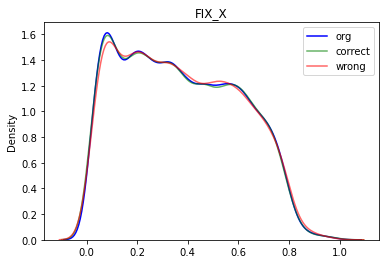

In [94]:


sns.kdeplot(x_test_gb_fix[:, 0], color='b', )
sns.kdeplot(x_test_gb_fix_crt[:, 0], color='g', alpha=.6)
sns.kdeplot(x_test_gb_fix_wrg[:, 0], color='r', alpha=.6)
plt.legend(["org", "correct", "wrong"])
plt.title("FIX_X")
plt.show()



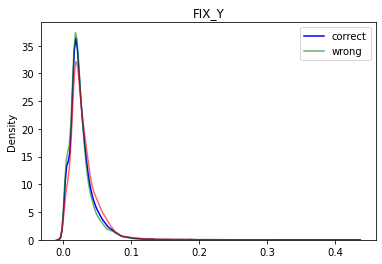

In [95]:


sns.kdeplot(x_test_gb_fix[:, 1], color='b', )
sns.kdeplot(x_test_gb_fix_crt[:, 1], color='g', alpha=.6)
sns.kdeplot(x_test_gb_fix_wrg[:, 1], color='r', alpha=.6)
plt.legend(["correct", "wrong"])

plt.title("FIX_Y")
plt.show()


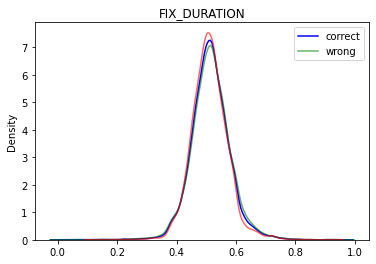

In [96]:

sns.kdeplot(x_test_gb_fix[:, 2], color='b', )
sns.kdeplot(x_test_gb_fix_crt[:, 2], color='g', alpha=.6)
sns.kdeplot(x_test_gb_fix_wrg[:, 2], color='r', alpha=.6)
plt.legend(["correct", "wrong"])

plt.title("FIX_DURATION")
plt.show()


# FIX_DEMO GP

In [32]:

results_gb_fix_demo = load_a_dict(
    name='dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:0',
    save_path=configs.results_path,
)



In [33]:

y_test_gb_fix_demo = results_gb_fix_demo['1']['y_test']
y_pred_gb_fix_demo = results_gb_fix_demo['1']['y_pred']
x_test_gb_fix_demo = results_gb_fix_demo['1']['x_test']


In [34]:


x_test_gb_fix_demo_wrg = x_test_gb_fix_demo[np.where(y_test_gb_fix_demo != y_pred_gb_fix_demo)]
x_test_gb_fix_demo_crt = x_test_gb_fix_demo[np.where(y_test_gb_fix_demo == y_pred_gb_fix_demo)]
x_test_gb_fix_demo_wrg.shape, x_test_gb_fix_demo_crt.shape




((2013, 13), (20522, 13))

In [56]:
x_org

,Grade_3,Grade_6,Grade_4,FIX_DURATION,Sex_1,Sex_2,FIX_Y,Grade_1,FIX_X,Age,IQ,Grade_5,Grade_2
0,0,0,1,219.0,1,0,531.8,0,177.3,10,23,0,0
1,0,0,1,247.0,1,0,545.2,0,200.5,10,23,0,0
2,0,0,1,261.0,1,0,542.4,0,282.7,10,23,0,0
3,0,0,1,268.0,1,0,545.5,0,358.1,10,23,0,0
4,0,0,1,129.0,1,0,536.3,0,392.8,10,23,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,1,0,0,160.0,0,1,562.7,0,743.3,10,32,0,0
512,1,0,0,193.0,0,1,555.8,0,772.5,10,32,0,0
513,1,0,0,219.0,0,1,561.9,0,941.7,10,32,0,0
514,1,0,0,144.0,0,1,548.8,0,831.8,10,32,0,0


0      177.3
1      200.5
2      282.7
3      358.1
4      392.8
       ...  
511    743.3
512    772.5
513    941.7
514    831.8
515    988.0
Name: FIX_X, Length: 225350, dtype: float64

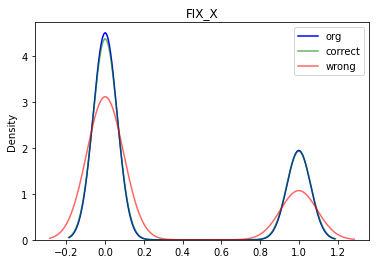

In [86]:

sns.kdeplot(x_test_gb_fix_demo[:, 8], color='b', )
sns.kdeplot(x_test_gb_fix_demo_crt[:, 8], color='g', alpha=.6)
sns.kdeplot(x_test_gb_fix_demo_wrg[:, 8], color='r', alpha=.6)
plt.legend(["org", "correct", "wrong"])
plt.title("FIX_X")
plt.show()



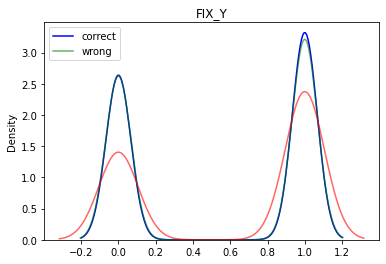

In [89]:


sns.kdeplot(x_test_gb_fix_demo[:, 6], color='b', )
sns.kdeplot(x_test_gb_fix_demo_crt[:, 6], color='g', alpha=.6)
sns.kdeplot(x_test_gb_fix_demo_wrg[:, 6], color='r', alpha=.6)
plt.legend(["correct", "wrong"])
plt.title("FIX_Y")
plt.show()




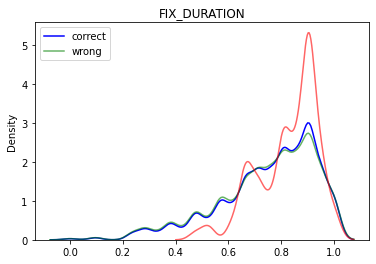

In [90]:

sns.kdeplot(x_test_gb_fix_demo[:, 3], color='b', )
sns.kdeplot(x_test_gb_fix_demo_crt[:, 3], color='g',  alpha=.6)
sns.kdeplot(x_test_gb_fix_demo_wrg[:, 3], color='r',  alpha=.6)
plt.legend(["correct", "wrong"])
plt.title("FIX_DURATION")
plt.show()
